# 0.0 IMPORTS

In [1]:
!pip3 install xgboost

In [2]:
!pip install tabulate

In [3]:
!pip install boruta

In [4]:
!pip install inflection

In [5]:
from sklearn.ensemble          import RandomForestRegressor
from sklearn.metrics           import mean_absolute_error,mean_squared_error
from sklearn.linear_model      import LinearRegression,Lasso
from sklearn.ensemble          import RandomForestRegressor,ExtraTreesRegressor
from tabulate                  import tabulate
from scipy                     import stats 
from sklearn.preprocessing     import RobustScaler,MinMaxScaler
from sklearn.preprocessing     import LabelEncoder
from boruta                    import BorutaPy
from IPython.display           import Image
from flask                     import Flask,request,Response
from sklearn.model_selection   import RandomizedSearchCV
from IPython.core.display      import HTML


import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
import xgboost             as xgb

import datetime
import inflection
import math
import random
import warnings
import pickle
import requests
import json

## 0.1 Helper Functions

In [6]:
def cramer_v(x,y):

  cm=pd.crosstab(x,y).to_numpy()
  n=cm.sum()
  r,k=cm.shape
  chi2=stats.chi2_contingency(cm)[0]
  chi2corr=max(0,chi2-(k-1)*(r-1)/(n-1))
  kcorr=k-(k-1)**2/(n-1)
  rcorr=r-(r-1)**2/(n-1)

  return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


def ml_error(model_name,y,yhat):

  mae=mean_absolute_error(y,yhat)
  mape=mean_absolute_percentage_error(y,yhat)
  rmse=np.sqrt(mean_squared_error(y,yhat))

  return pd.DataFrame({    'Model Name':  model_name,
                           'MAE':         mae,
                           'MAPE':        mape,
                           'RMSE':        rmse       },index=[0])
  
    
def mean_percentage_error(y,yhat):
  return np.mean((y-yhat)/y)


def mean_absolute_percentage_error(y,yhat):
  return np.mean(np.abs((y-yhat)/y))


def cross_validation(x_training,kfold,model_name,model,verbose=False):
  mae_list=[]
  mape_list=[]
  rmse_list=[]

  for K in reversed(range(1,kfold+1)):
    if verbose==True:
      print('\nKFold Number: {}'.format(K))
    #Start and end date for validation
    validation_start_date=x_training['date'].max()-datetime.timedelta(days=K*6*7)
    validation_end_date=x_training['date'].max()-datetime.timedelta(days=(K-1)*6*7)

    #Filtering in dataset
    training=x_training[x_training['date']<validation_start_date]
    validation=x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]

    #Training and validation dataset
    #Training
    xtraining=training.drop(['date','sales'],axis=1)
    ytraining=training['sales']

    #Validation
    xvalidation=validation.drop(['date','sales'],axis=1)
    yvalidation=validation['sales']

    #model
    m=model.fit(xtraining,ytraining)

    #prediction
    yhat=m.predict(xvalidation)

    #performance
    m_results=ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))
    print(m_results)

    #Store performance of each KFold iteration
    mae_list.append(m_results['MAE'])
    mape_list.append(m_results['MAPE'])
    rmse_list.append(m_results['RMSE'])

  return pd.DataFrame({'Model name':model_name,'MAE CV':np.round(np.mean(mae_list),2).astype(str)+' +/- '+ np.round(np.std(mae_list),2).astype(str),
                       'MAPE CV':   np.round(np.mean(mape_list),2).astype(str)+' +/- '+ np.round(np.std(mape_list),2).astype(str),
                       'RMSE CV':   np.round(np.mean(rmse_list),2).astype(str)+' +/- '+ np.round(np.std(rmse_list),2).astype(str)},index=[0]) 
  
def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0.2 Loading Data

In [8]:
df_sales_raw=pd.read_csv('/content/train.csv',low_memory=False)
df_store_raw=pd.read_csv('/content/store.csv',low_memory=False)

#merge
df_raw=pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DESCRIPTION OF THE DATA

## 1.1 Rename Columns


In [9]:
df1=df_raw.copy()

cols_old=([  'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
             'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
             'CompetitionDistance', 'CompetitionOpenSinceMonth',
             'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
             'Promo2SinceYear', 'PromoInterval'])

snakecase= lambda x : inflection.underscore(x)
cols_new=list(map(snakecase,cols_old))

#rename
df1.columns=cols_new

## 1.2 Data Dimensions


In [10]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3 Data Types

In [11]:
df1['date']=pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA


In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [13]:
#competition_distance
df1['competition_distance'].max()
max_value=200000
df1['competition_distance']=df1['competition_distance'].apply(lambda x : max_value if math.isnan(x) else x)    

#competition_open_since_month 
df1['competition_open_since_month']=df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1) 

#competition_open_since_year 
df1['competition_open_since_year']=df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1) 
    
#promo2
#promo2_since_week
df1['promo2_since_week']=df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)  

#promo2_since_year  
df1['promo2_since_year']=df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)  

#promo_interval 
month_map={1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dev'}   
df1['promo_interval'].fillna(0,inplace=True) 
df1['month_map']=df1['date'].dt.month.map(month_map)  
df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(';') else 0,axis=1)        

In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change types


In [15]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']=  df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']=            df1['promo2_since_week'].astype(int)
df1['promo2_since_year']=            df1['promo2_since_year'].astype(int)

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical


In [17]:
num_attributes=df1.select_dtypes(include=['int64','float64'])
cat_attributes=df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
#Central tendency=mean,median
ct1=pd.DataFrame(num_attributes.apply(np.mean)).T
ct2=pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion=std,min,max,range,skew,kurtosis
d1=pd.DataFrame(num_attributes.apply(np.std)).T
d2=pd.DataFrame(num_attributes.apply(min)).T
d3=pd.DataFrame(num_attributes.apply(max)).T
d4=pd.DataFrame(num_attributes.apply(lambda x:x.mean()-x.min())).T
d5=pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6=pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

#Concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()  
m.columns=(['attributes','min','max','range','mean','median','std','skew','kurtosis'])  
m  

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,557.429727,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,2.998341,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,5773.818972,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,633.145946,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,0.830107,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,0.381515,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,0.178647,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,5915.442677,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,5.786849,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,110.324840,2010.324840,2012.0,5.515591,-7.235657,124.071304


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


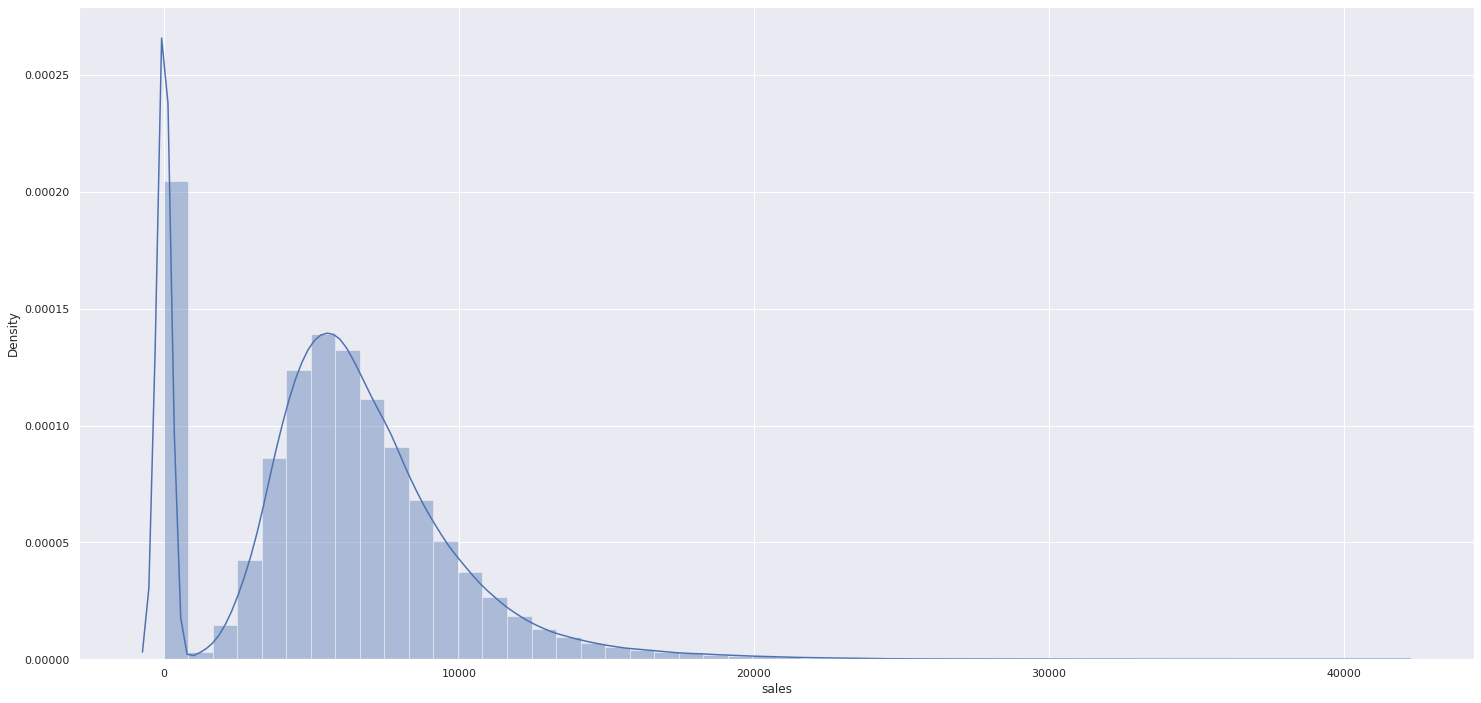

In [19]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical attributes

In [20]:
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

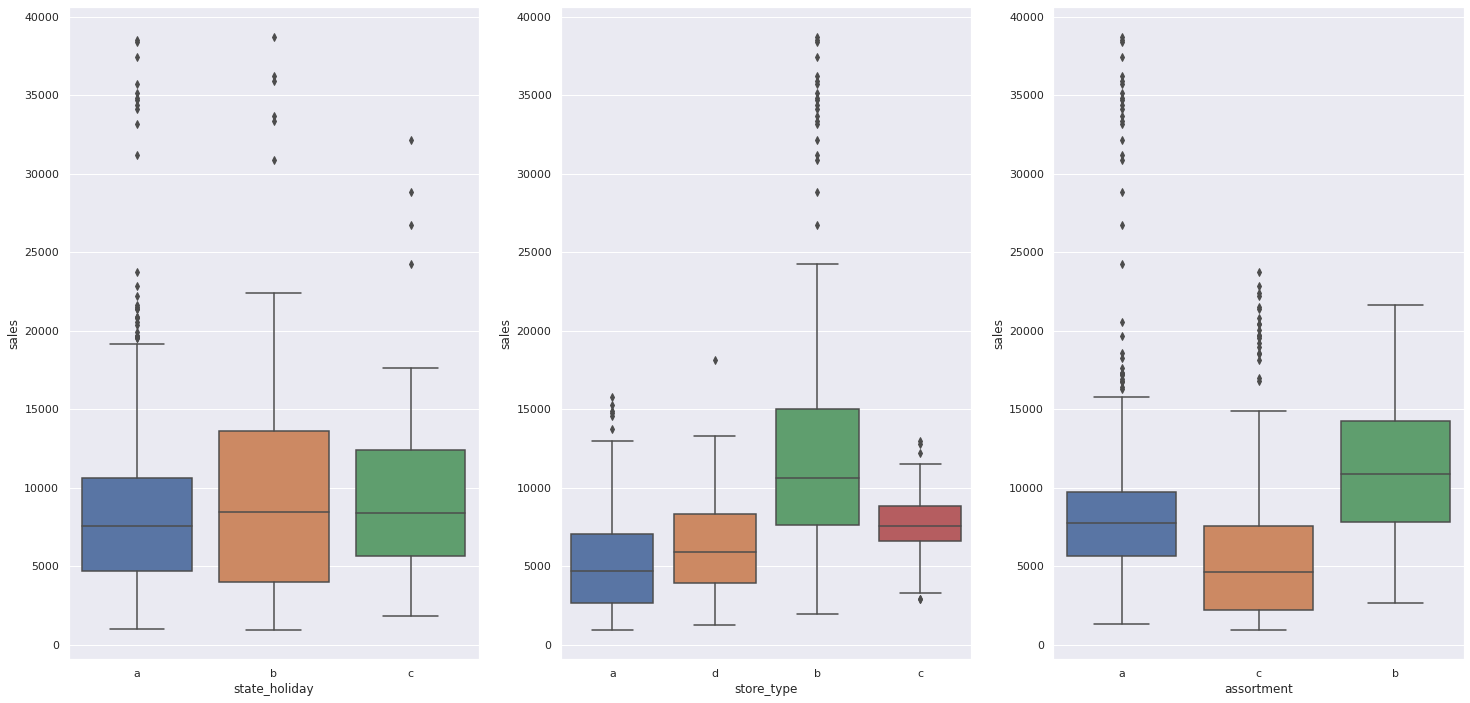

In [21]:
aux1=df1[(df1['state_holiday'] !='0') & (df1['sales']>0)]

plt.subplot(1,3,1)
ax=sns.boxplot(x='state_holiday',y='sales',data=aux1)


plt.subplot(1,3,2)
ax=sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
ax=sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis mind map

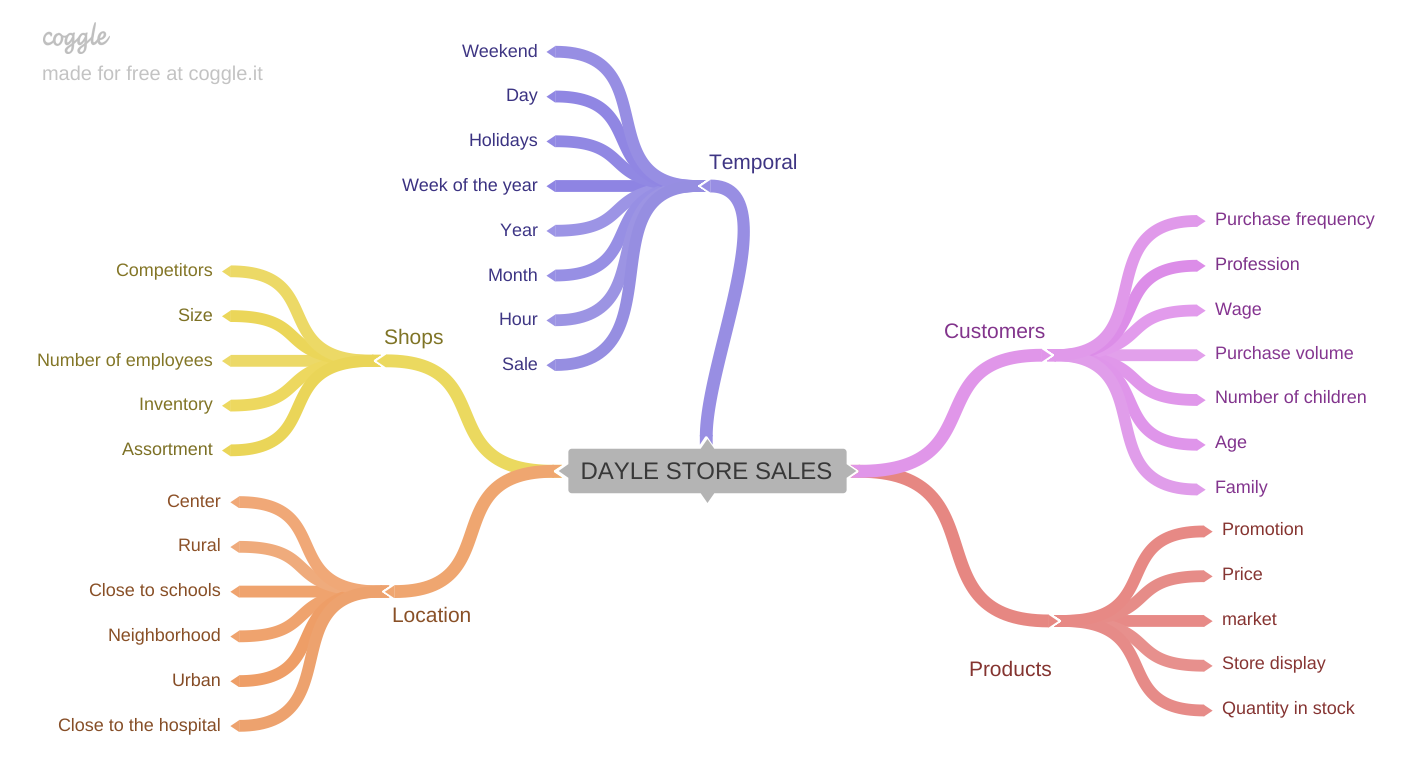

In [22]:
Image('/content/DAYLE_STORE_SALES.png')

## 2.2 Creation of hypotheses

### 2.1.1 Store Hypotheses

**1.** Stores with larger staff should sell more.

**2.** Stores with more inventory should sell more.

**3.** Larger stores should sell more.

**4.** Smaller stores should sell less.

**5.** Stores with a larger assortment should sell more.

### 2.1.2 Product Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that display more products in their windows should sell more.

**3.** Stores that have lower prices on products should sell more.

**4.** Stores that have lower prices for longer on products should sell more.

### 2.1.3 Assumptions Time

**1.** Stores that have longer holidays should sell less.

**2.** Stores that open within the first 6 months should sell more.

**3.** Stores that open on weekends should sell more.

## 2.2 Final list of hypotheses

**1-**Stores with a larger assortment should sell more.

**2-**Stores with closer competitors should sell less.

**3-**Stores with longer-term competitors should sell more.

**4-**Stores with promotions active for longer should sell more.

**5-**Stores with more promotion days should sell more.

**6-**Stores with more consecutive promotions.

**7-**Stores open during the Christmas holiday should sell more.

**8-**Stores should sell more over the years.

**9-**Stores should sell more in the second half of the year.

**10-**Stores should sell more after the 10th of each month.

**11-**Stores should sell less of the week's movies.

**12-**Stores should sell less during school holidays.


In [23]:
df2=df1.copy()

## 2.3 Feature Engineering


In [24]:
#year
df2['year']=df2['date'].dt.year

#month
df2['month']=df2['date'].dt.month

#day
df2['day']=df2['date'].dt.day

#week of year
df2['week_of_year']=df2['date'].dt.weekofyear

#year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1' ,'%Y-%W-%w')-datetime.timedelta(days=7))
df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

#assortment
df2['assortment']=df2['assortment'].apply(lambda x:'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday']=df2['state_holiday'].apply(lambda x:'puplic_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  # This is added back by InteractiveShellApp.init_path()


In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. VARIABLES FILTERING

In [26]:
df3=df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,0,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,0,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Line Filtering


In [27]:
df3=df3[(df3['open']!=0)&(df3['sales']>0)]

## 3.2. Column selection

In [28]:
cols_drop=['customers','open','promo_interval','month_map']
df3=df3.drop(cols_drop,axis=1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [29]:
df4=df3.copy()

## 4.1 Univariate Analysis

### 4.1.1. Response Variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


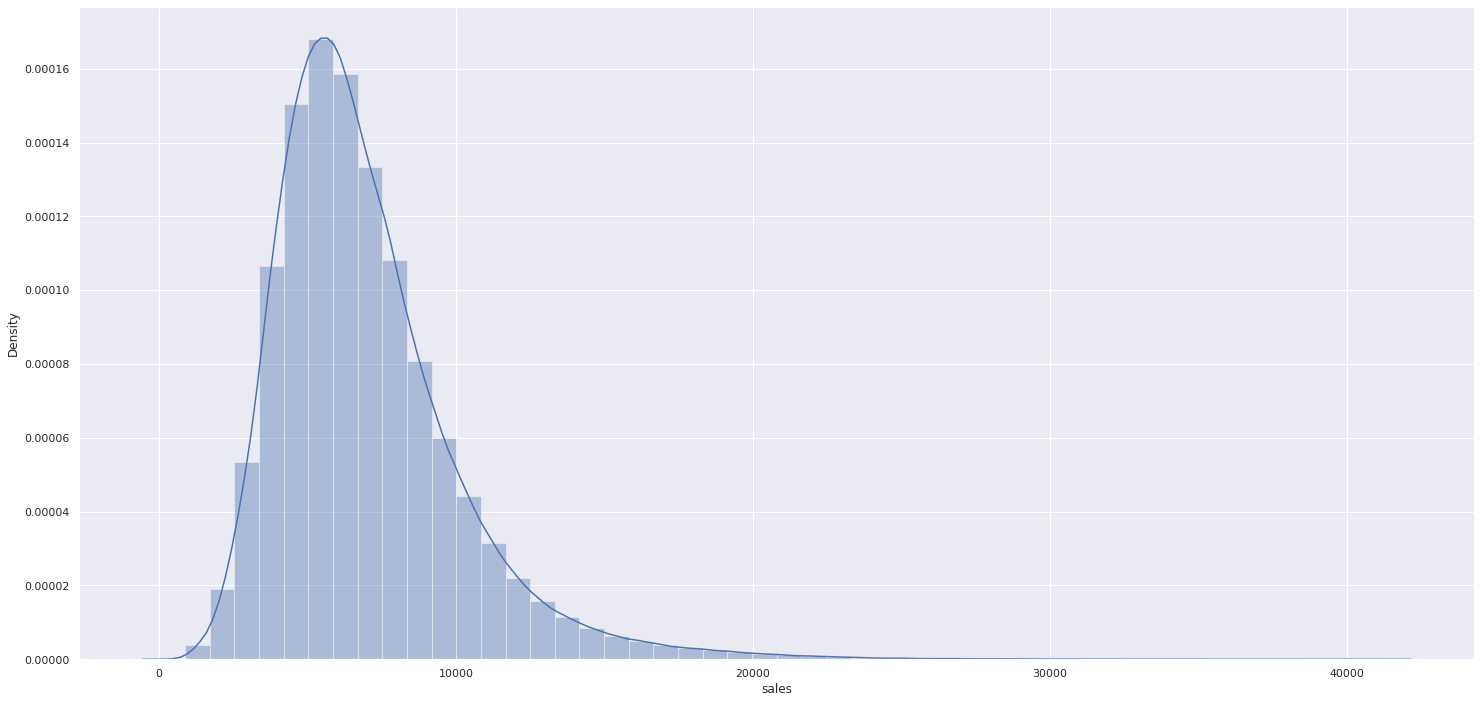

In [30]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

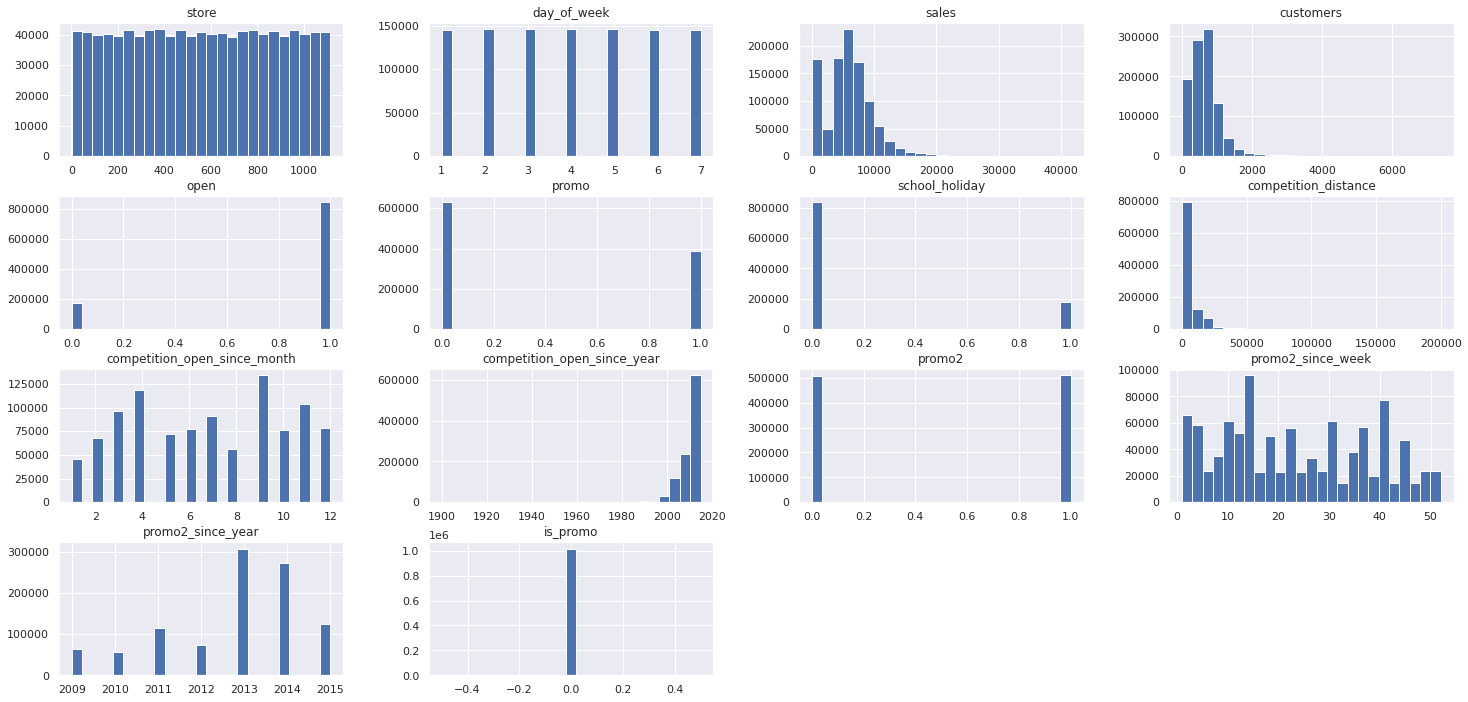

In [31]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variable

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


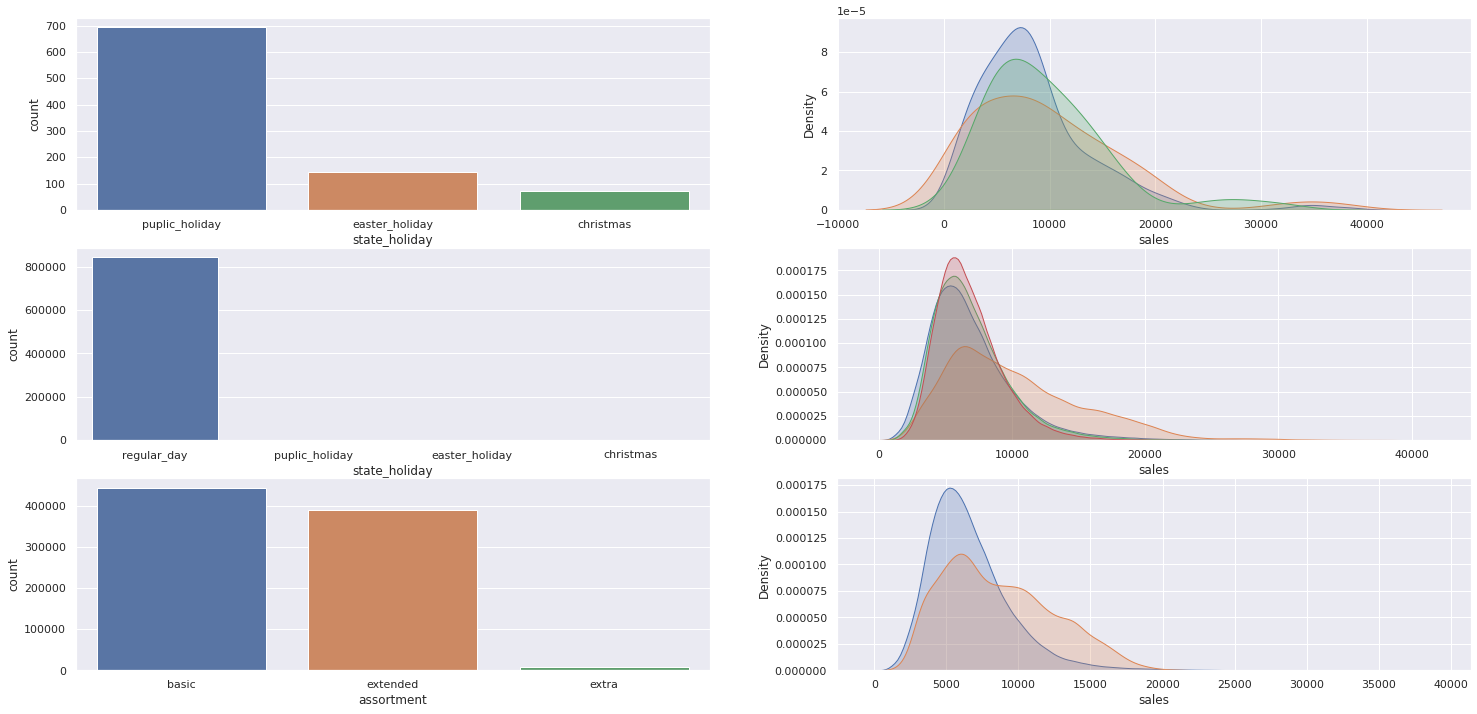

In [32]:
#state_holiday
plt.subplot(3,2,1)
a=df4[df4['state_holiday'] != 'regular_day']
ax=sns.countplot(a['state_holiday'])


plt.subplot(3,2,2)
ax=sns.kdeplot(df4[df4['state_holiday']=='puplic_holiday']['sales'],label='public_holiday',shade=True)
ax=sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade=True)
ax=sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',shade=True)

#store_type
plt.subplot(3,2,3)
ax=sns.countplot(df4['state_holiday'])

plt.subplot(3,2,4)
ax=sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',shade=True)
ax=sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',shade=True)
ax=sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',shade=True)
ax=sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',shade=True)

#assortment
plt.subplot(3,2,5)
ax=sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
ax=sns.kdeplot(df4[df4['assortment']=='extend']['sales'],label='extend',shade=True)
ax=sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',shade=True)
ax=sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',shade=True)

## 4.2 Bivariate Analysis

### ***H1***. Stores with a larger assortment should sell more.  (FALSE)

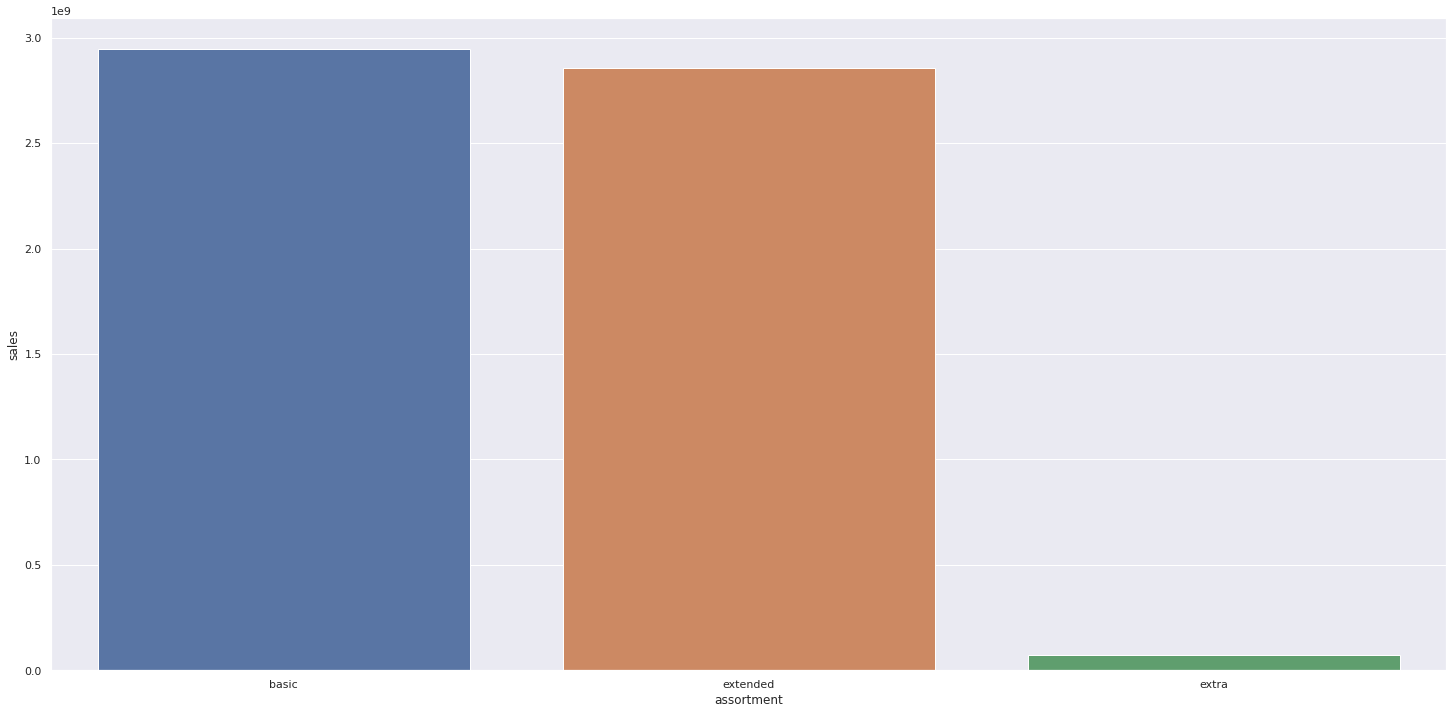

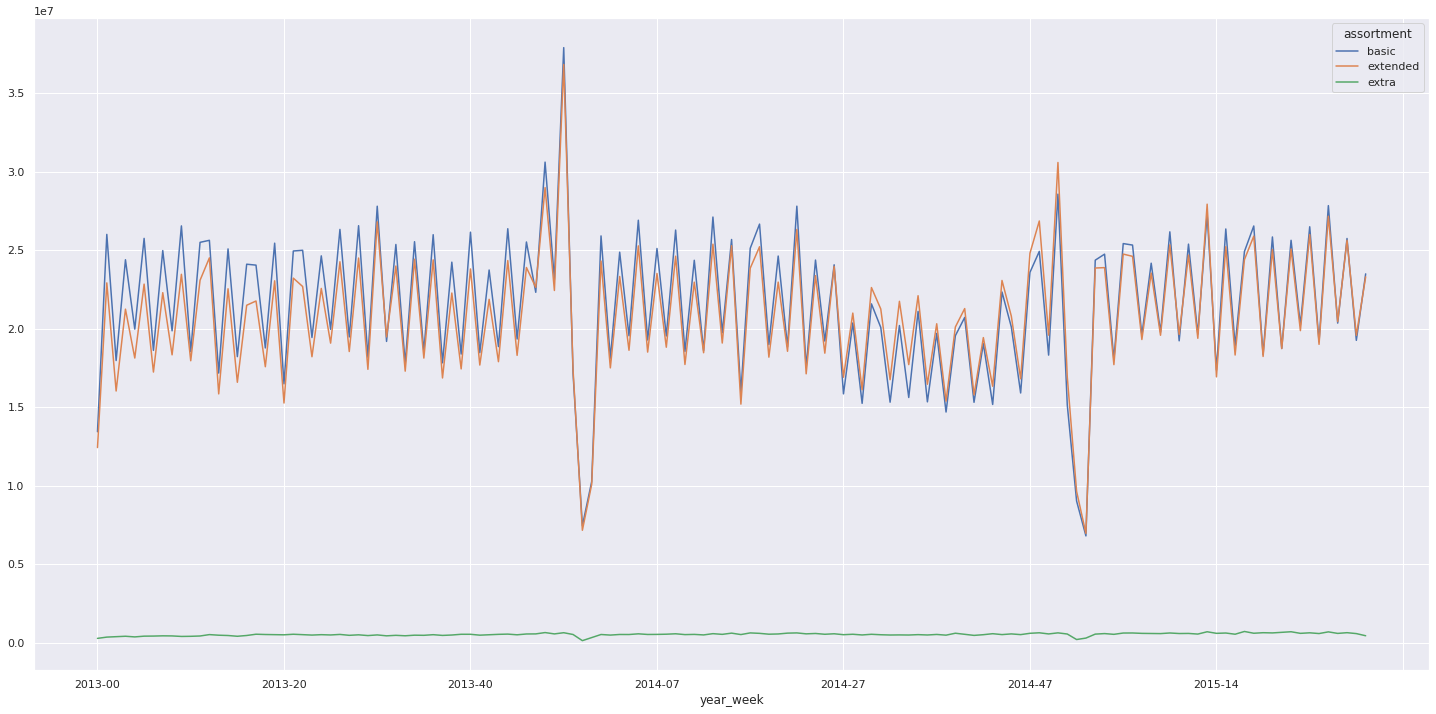

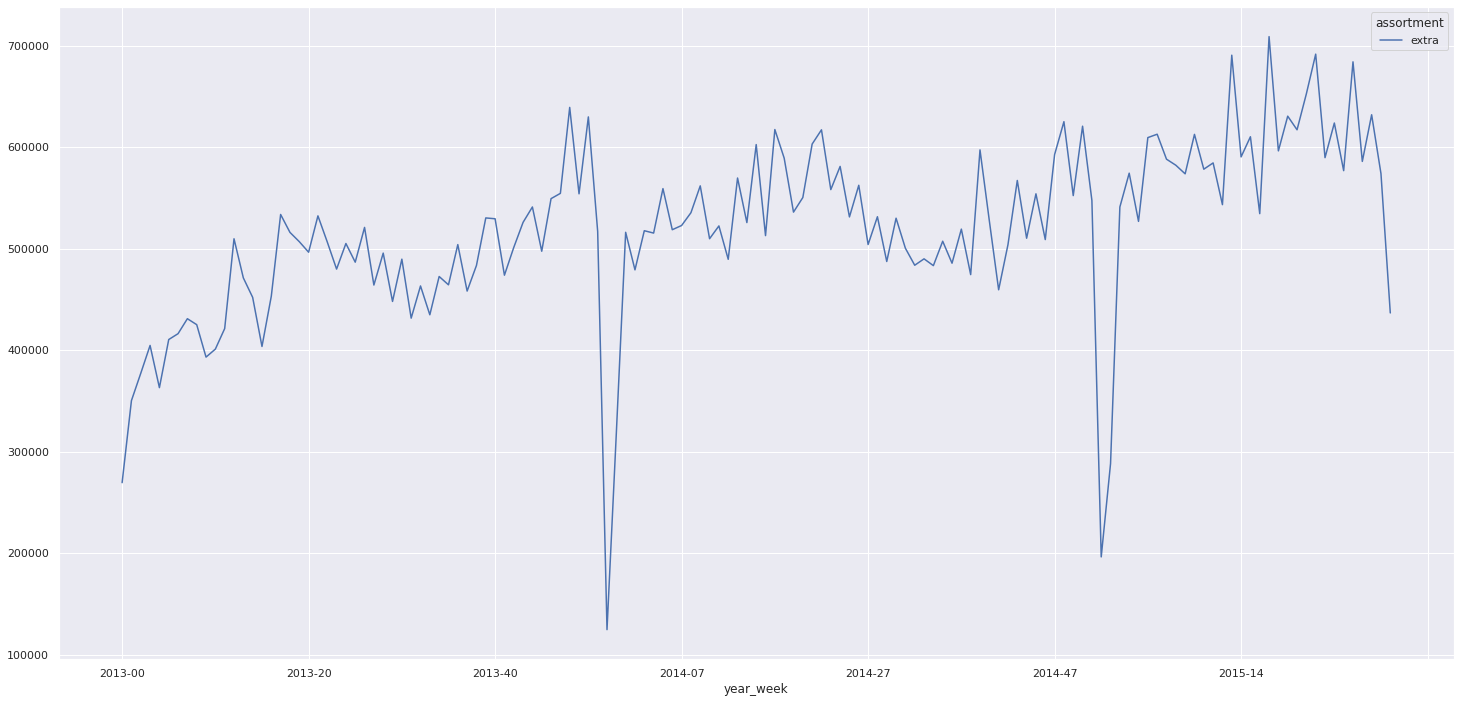

In [33]:
aux1=df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2=df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

aux3=aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### ***H2***. Stores with closer competitors should sell less. (FALSE)

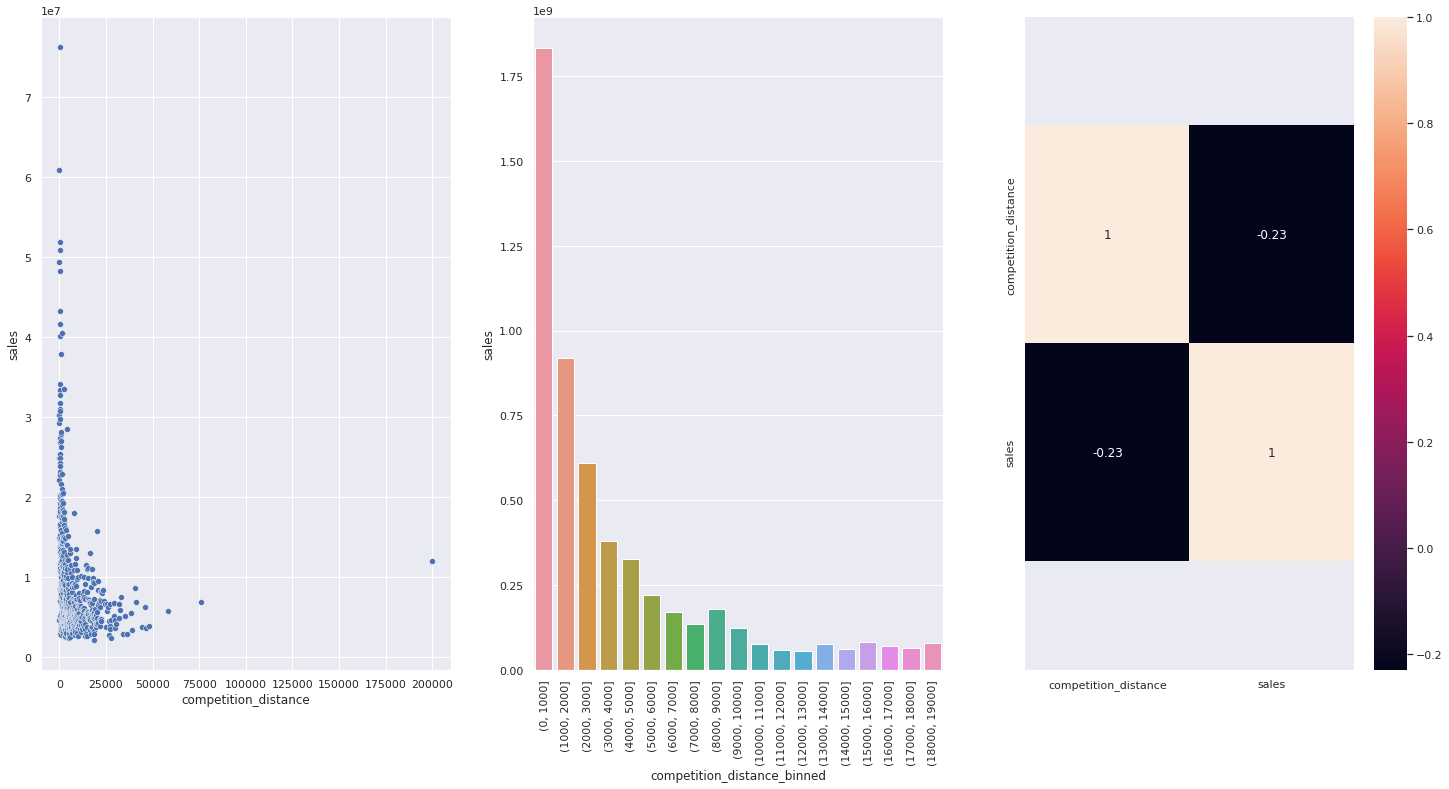

In [34]:
aux1=df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

plt.subplot(1,3,2)
bins=list(np.arange(0,20000,1000))
aux1['competition_distance_binned']=pd.cut(aux1['competition_distance'],bins=bins)
aux2=aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top=x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);

### ***H3***. Stores with longer-term competitors should sell more. (FALSE)


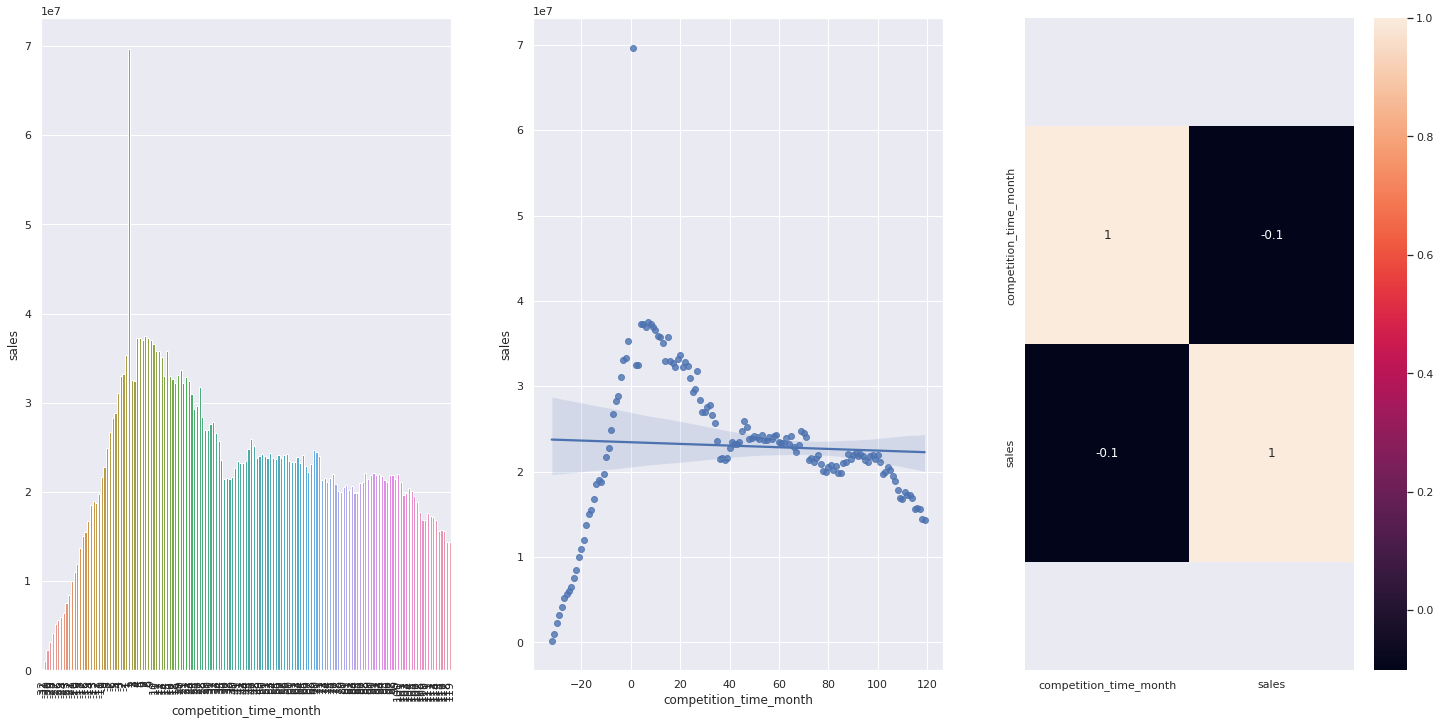

In [35]:
plt.subplot(1,3,1)
aux1=df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2=aux1[(aux1['competition_time_month']<120)&(aux1['competition_time_month']!=0)]

sns.barplot(x='competition_time_month',y='sales',data=aux2)
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month',y='sales',data=aux2)

plt.subplot(1,3,3)
x=sns.heatmap(aux1.corr(method='pearson'),annot=True);
bottom,top=x.get_ylim()
x.set_ylim(bottom+0.5,top-0.5);

### ***H4***. Stores with promotions active for longer should sell more. (FALSE)

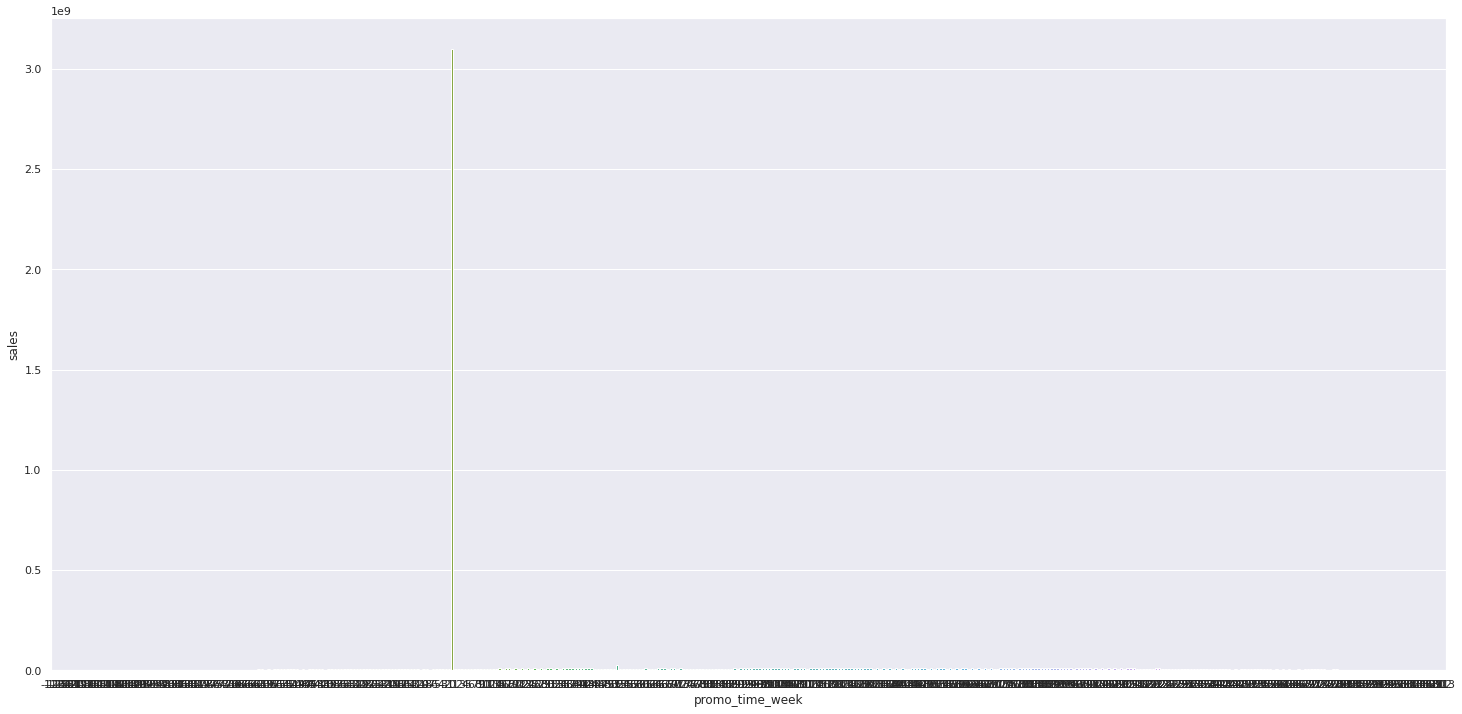

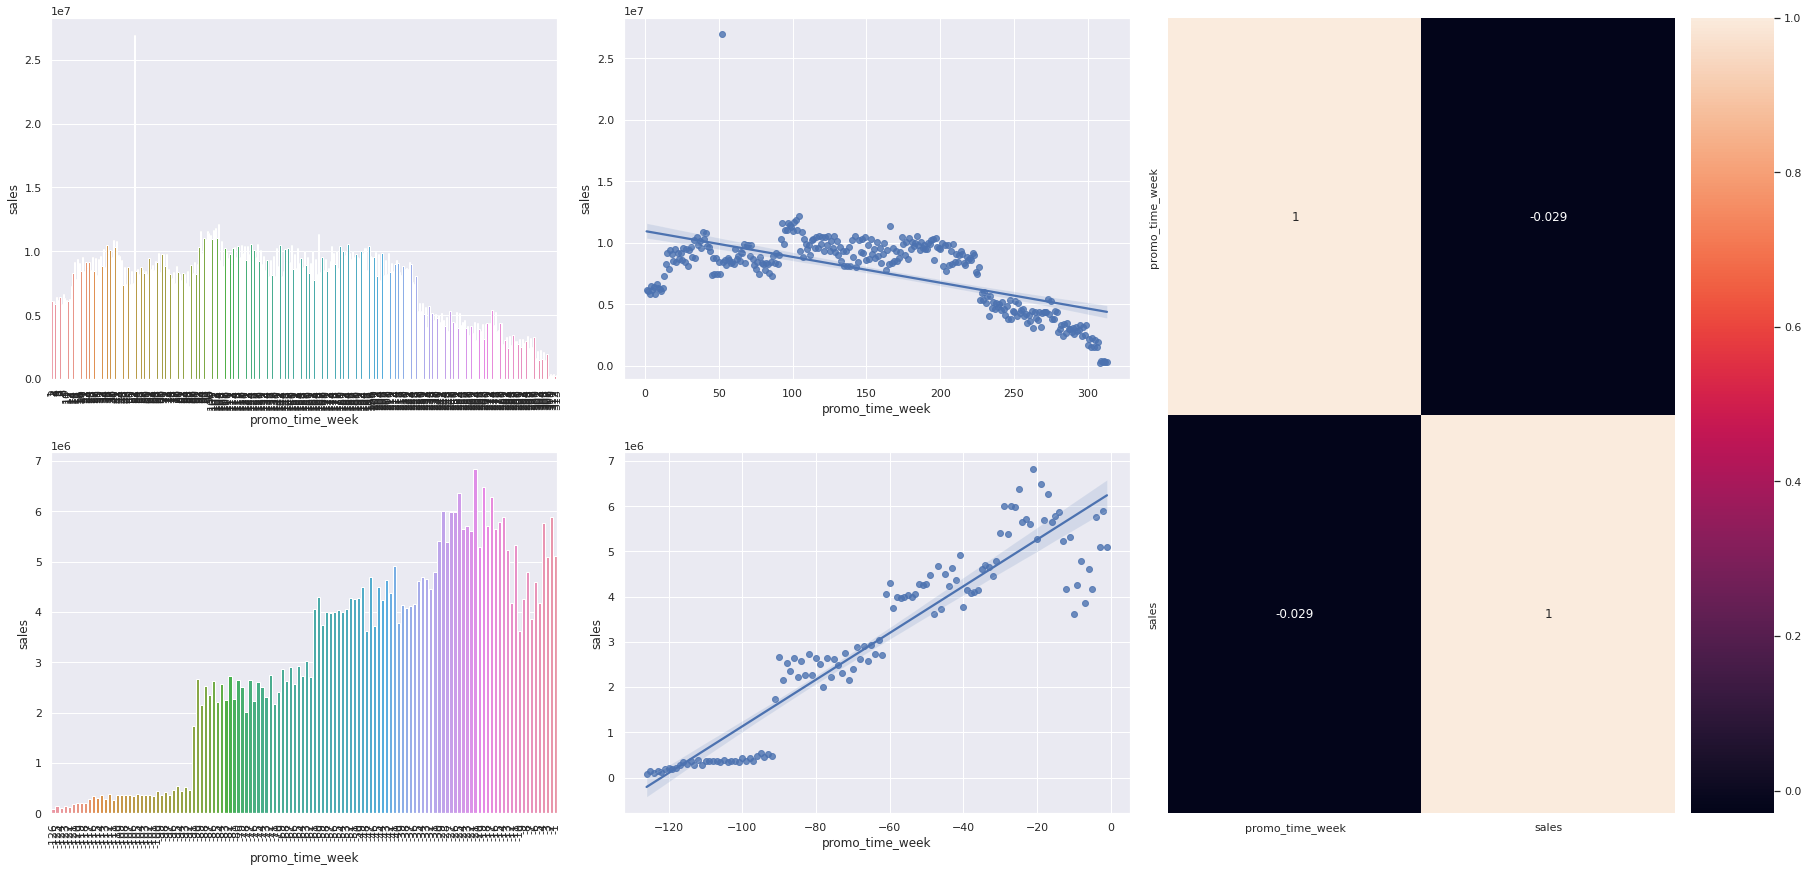

In [36]:
aux1=df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
sns.barplot(x='promo_time_week',y='sales',data=aux1);

fig2 = plt.figure(constrained_layout=True)
grid=spec2 = gridspec.GridSpec(ncols=3, nrows=2, figure=fig2)

plt.subplot(grid[0,0])
aux2=aux1[aux1['promo_time_week']>0]#promo extend
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3=aux1[aux1['promo_time_week']<0]#promo regular
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### ***H5***. Stores with more promotion days should sell more.(OFF)


### ***H6***. Stores with more consecutive promotions. (FALSE)

In [37]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


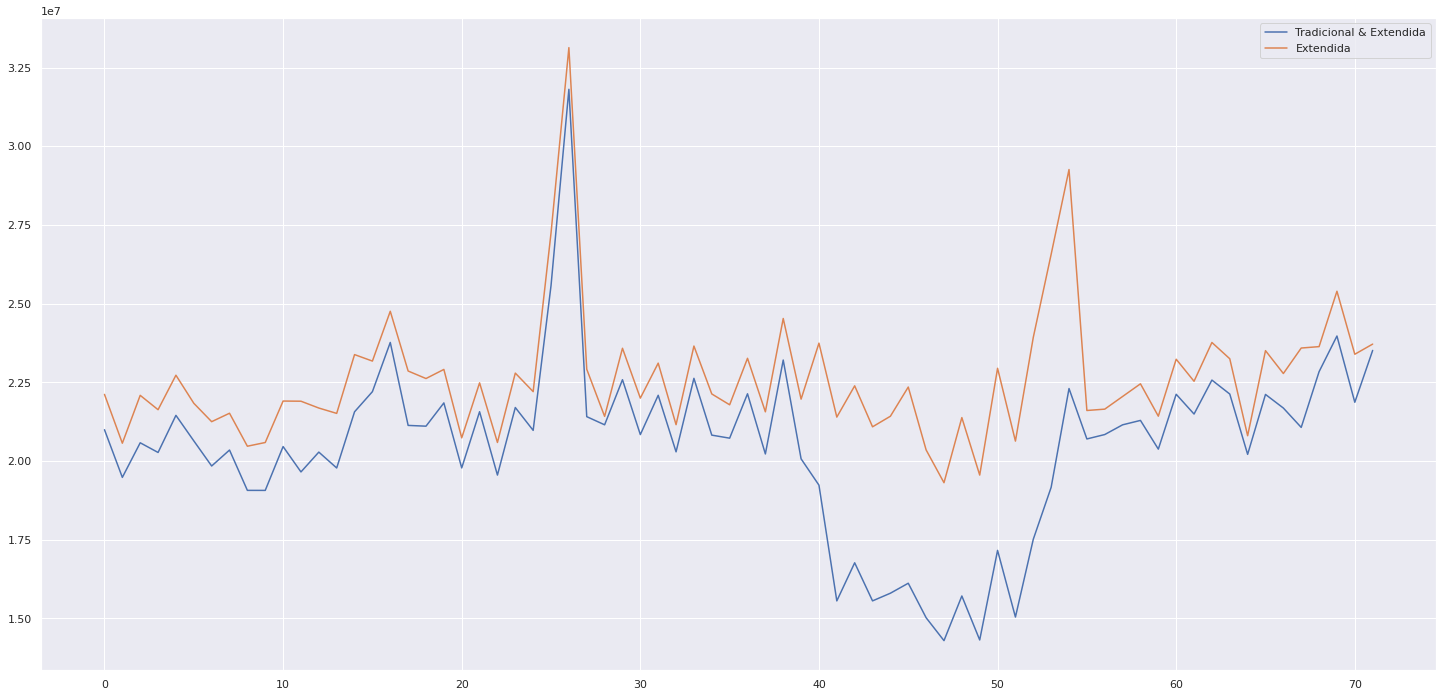

In [38]:
aux1=df4[(df4['promo']==1)&(df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax=aux1.plot();

aux2=df4[(df4['promo']==1)&(df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida','Extendida'])

### ***H7***. Stores open during the Christmas holiday should sell more. (FALSE)

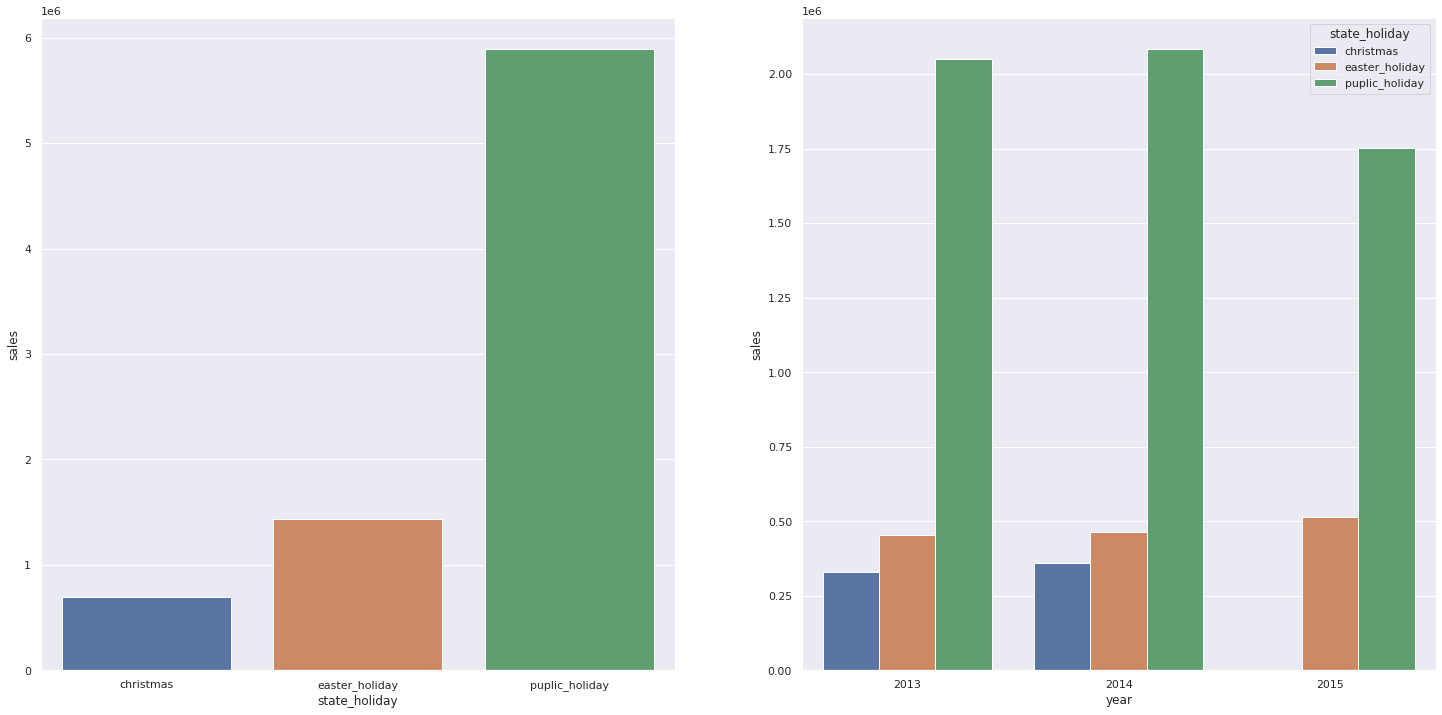

In [39]:
plt.subplot(1,2,1)
aux=df4[df4['state_holiday']!='regular_day']
aux1=aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
ax=sns.barplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2=aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
ax=sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### ***H8***. Stores should sell more over the years.(FALSE)

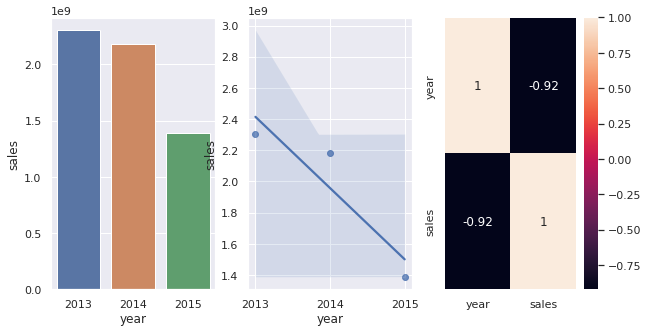

In [40]:
aux1=df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
ax=sns.barplot(x='year',y='sales',data=aux1);
ax.figure.set_size_inches(10,5)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### ***H9***. Stores should sell more in the second half of the year. (FALSE)

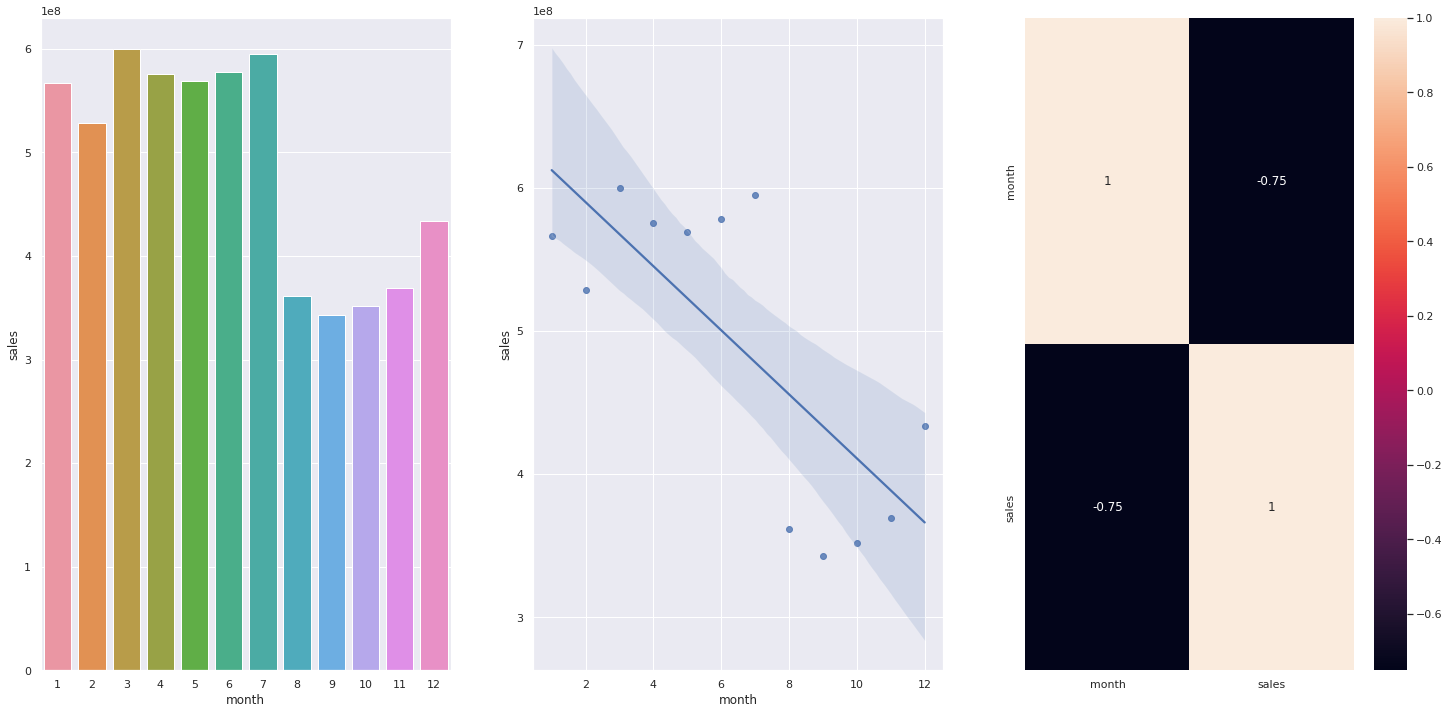

In [41]:
aux1=df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
ax=sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
ax=sns.regplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,3)
ax=sns.heatmap(aux1.corr(method='pearson'),annot=True);

### ***H10***. Stores should sell more after the 10th of each month. (TRUE)

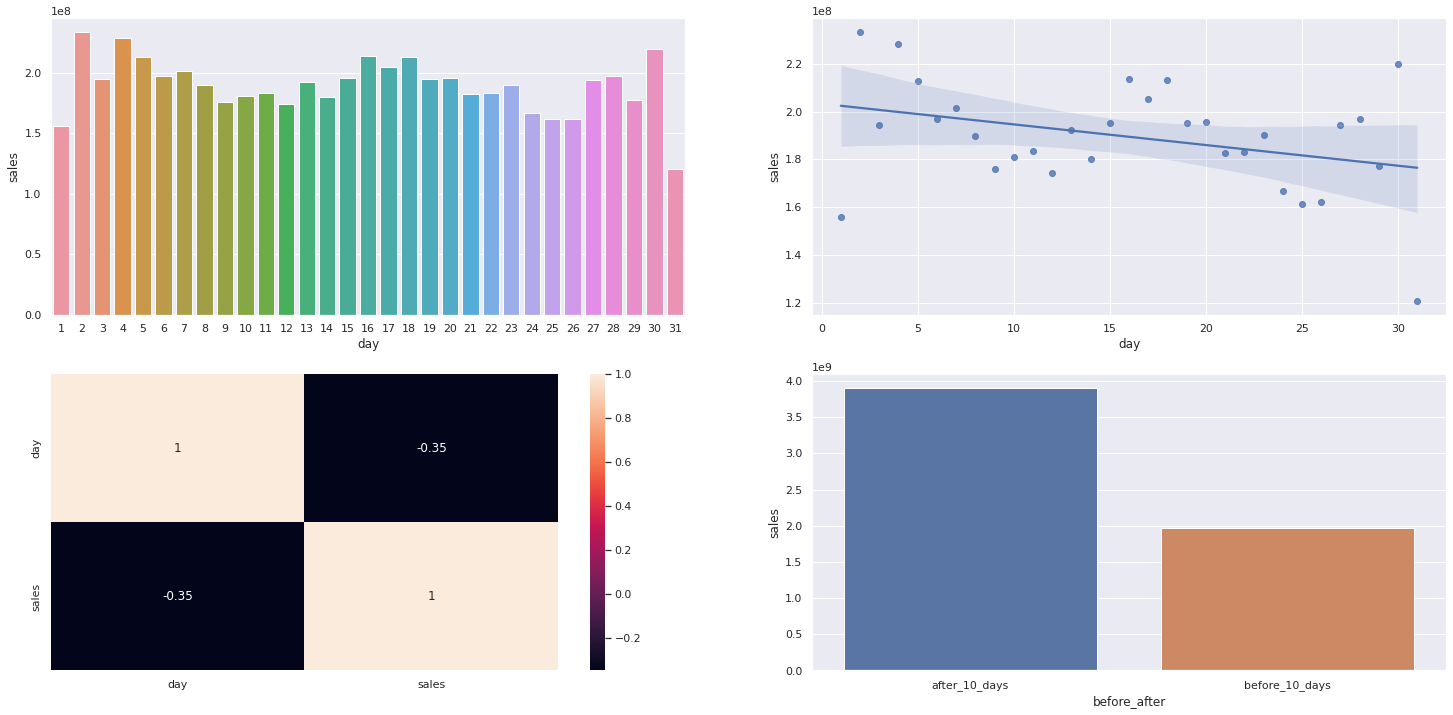

In [42]:
aux1=df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
ax=sns.barplot(x='day',y='sales',data=aux1);


plt.subplot(2,2,2)
ax=sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
ax=sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after']=aux1['day'].apply(lambda x:'before_10_days' if x<=10 else 'after_10_days')
aux2=aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
ax=sns.barplot(x='before_after',y='sales',data=aux2)

### ***H11***. Stores should sell less at the end of the week. (TRUE)

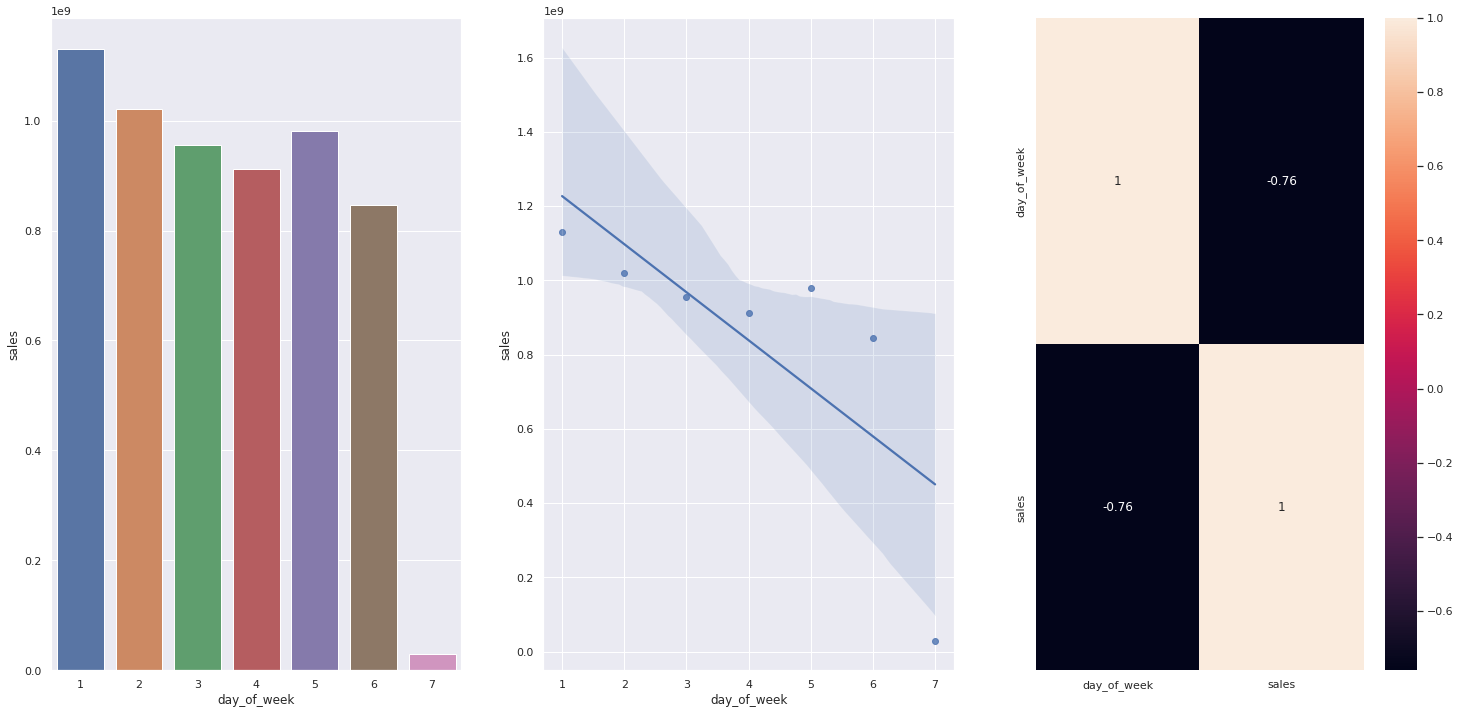

In [43]:
aux1=df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
ax=sns.barplot(x='day_of_week',y='sales',data=aux1);


plt.subplot(1,3,2)
ax=sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
ax=sns.heatmap(aux1.corr(method='pearson'),annot=True);

### ***H12***. Stores should sell less during school holidays. (TRUE)


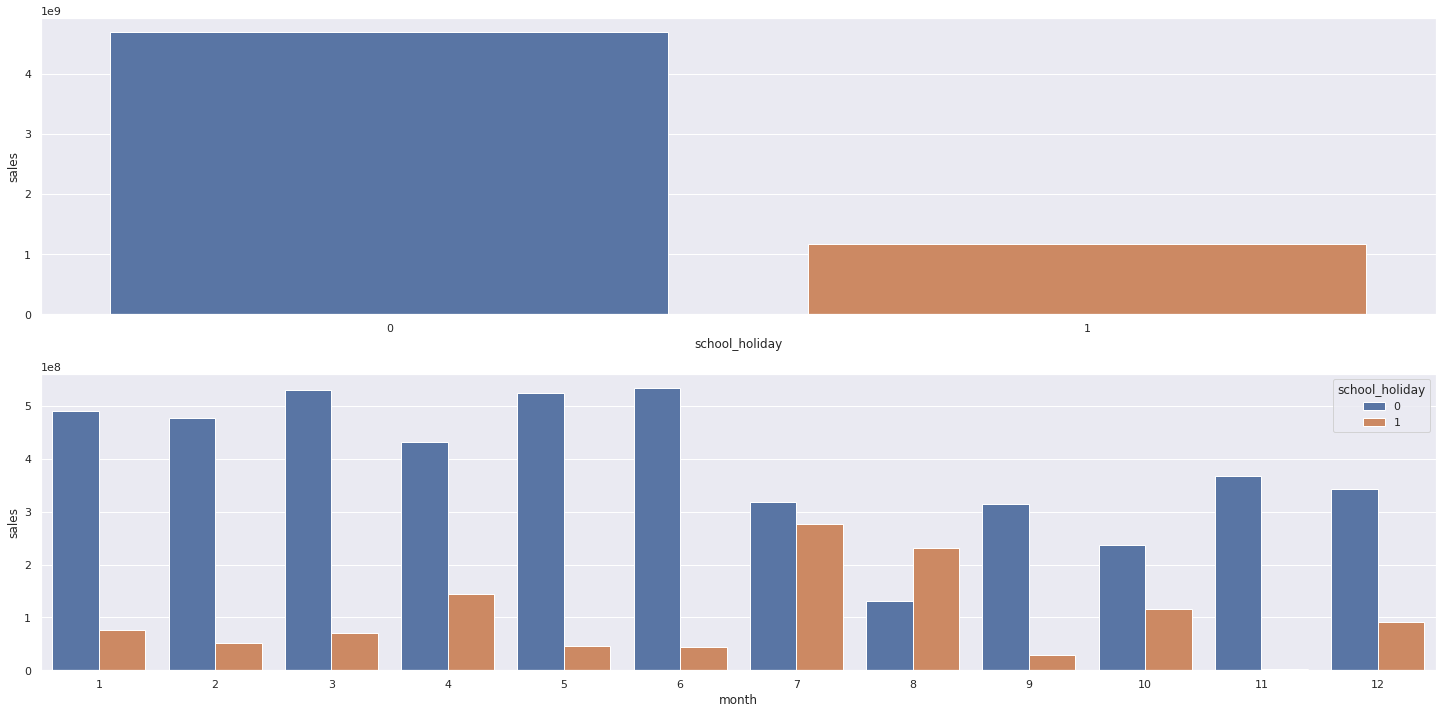

In [44]:
plt.subplot(2,1,1)
aux1=df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
ax=sns.barplot(x='school_holiday',y='sales',data=aux1);


aux2=df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
ax=sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

### 4.2.1 Summary of hypotheses

In [45]:
tab=[['Hypotheses','Conclusion',  'Relevance'],
     ['H1',        'False',       'Low'],
     ['H2',        'False',       'Medium'],
     ['H3',        'False',       'Medium'],
     ['H4',        'False',       'Low'],
     ['H5',        '-',           '-'],
     ['H6',        'False',       'Low'],
     ['H7',        'False',       'Medium'],
     ['H8',        'False',       'Low'],
     ['H9',        'False',       'Medium'],
     ['H10',       'True',        'High'],
     ['H11',       'True',        'High'],
     ['H12',       'True',        'Low']]

print(tabulate(tab,headers='firstrow'))

Hypotheses    Conclusion    Relevance
------------  ------------  -----------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            -             -
H6            False         Low
H7            False         Medium
H8            False         Low
H9            False         Medium
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate Analysis

### 4.3.1. Numerical Atributes

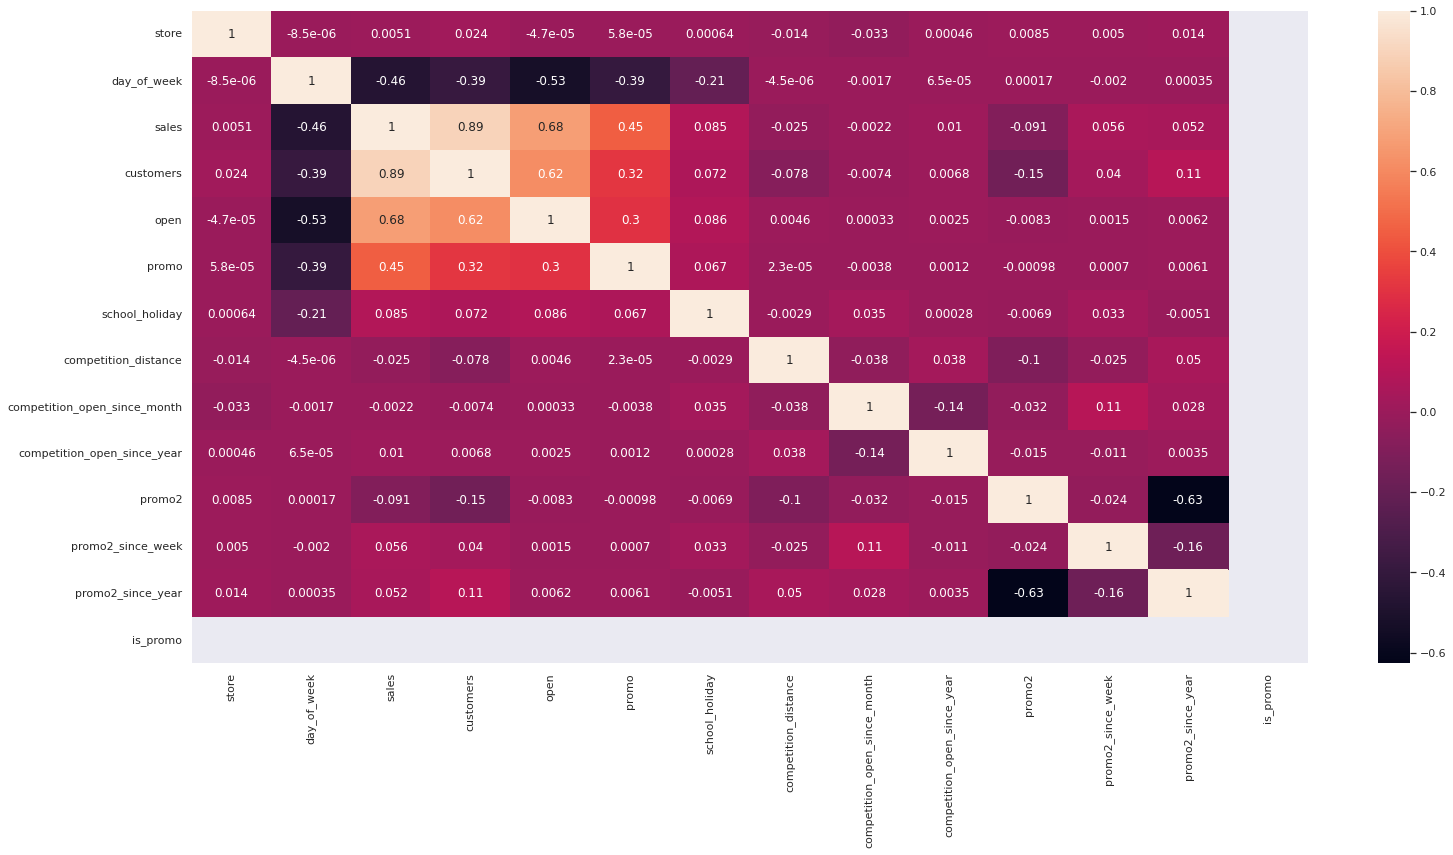

In [46]:
correlation=num_attributes.corr(method='pearson')
ax=sns.heatmap(correlation,annot=True);


### 4.3.2. Categorical Atributes

In [47]:
a=df4.select_dtypes(include='object')

In [48]:
a1=cramer_v(a['state_holiday'],a['state_holiday'])
a2=cramer_v(a['state_holiday'],a['store_type'])
a3=cramer_v(a['state_holiday'],a['assortment'])

a4=cramer_v(a['store_type'],a['state_holiday'])
a5=cramer_v(a['store_type'],a['store_type'])
a6=cramer_v(a['store_type'],a['assortment'])

a7=cramer_v(a['assortment'],a['state_holiday'])
a8=cramer_v(a['assortment'],a['store_type'])
a9=cramer_v(a['assortment'],a['assortment'])

d=pd.DataFrame({   'state_holiday':     [a1,a2,a3],
                   'store_type':        [a4,a5,a6],
                   'assortment':        [a7,a8,a9]})

d=d.set_index(d.columns)

d.head()

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


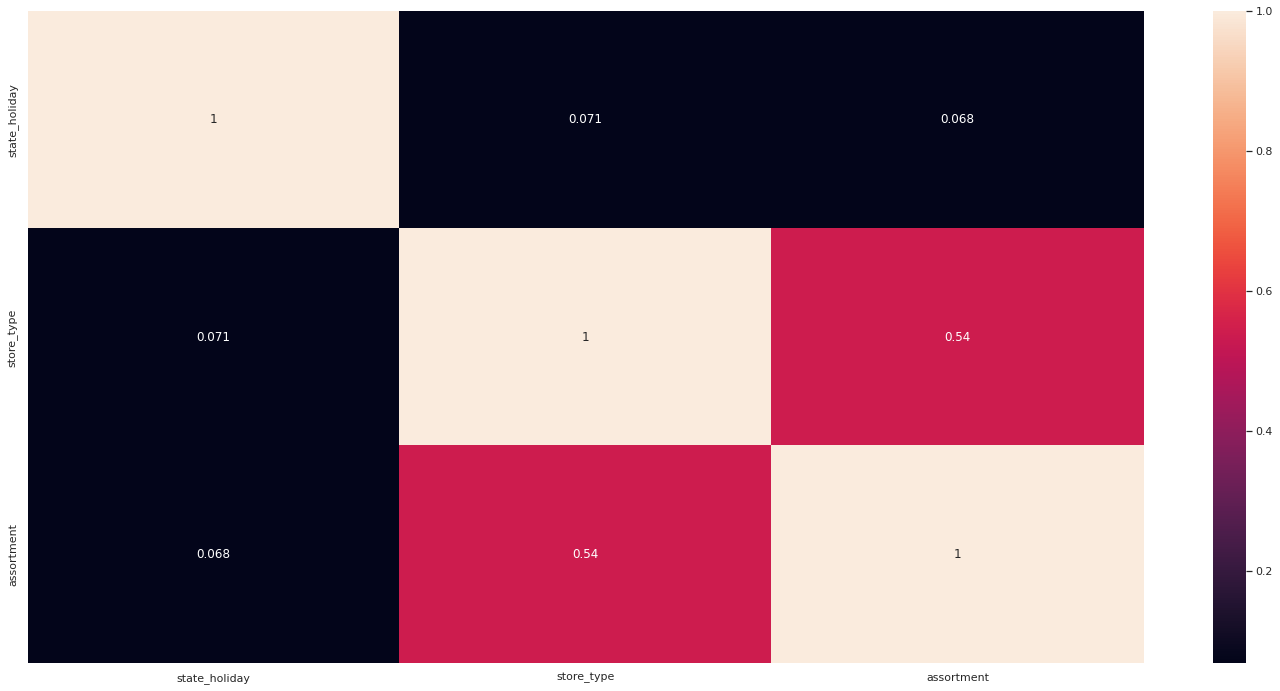

In [49]:
sns.heatmap(d,annot=True)

# 5.0. DATA PREPARATION

## 5.1. Normalization

## 5.2. Rescaling

In [50]:
df5=df4.copy()

a=df5.select_dtypes(include=['int64','float64'])

In [51]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,0,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,0,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


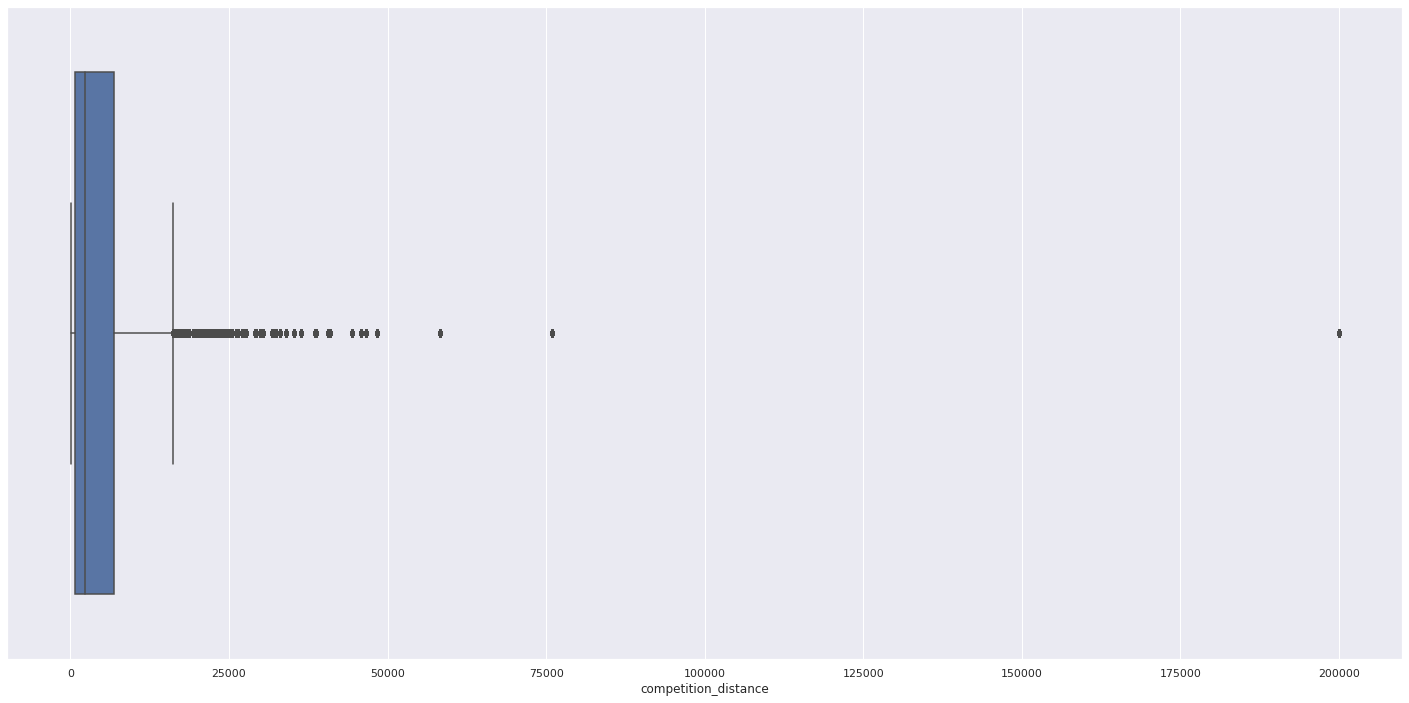

In [52]:
sns.boxplot(df5['competition_distance'])

In [53]:
rs=RobustScaler()
mms=MinMaxScaler()

#competition distance
df5['competition_distance']=rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs,open('/content/competition_distance_scaler.pkl','wb'))

#competition time month
df5['competition_time_month']=rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs,open('/content/competition_time_month_scaler.pkl','wb'))

#promo time week  
df5['promo_time_week']=mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs,open('/content/promo_time_week_scaler.pkl','wb'))

#year
df5['year']=mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('/content/year_scaler.pkl','wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [54]:
#state_holiday- One Hot Encoding
df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

#store_type- Label Encoding
le=LabelEncoder()
df5['store_type']=le.fit_transform(df5['store_type'])
pickle.dump(le,open('/content/store_type_scaler.pkl','wb'))

#assortment- Ordinal Encoding
assortment_dict={'basic':1,'extra':2,'extended':3}
df5['assortment']=df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable transformation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


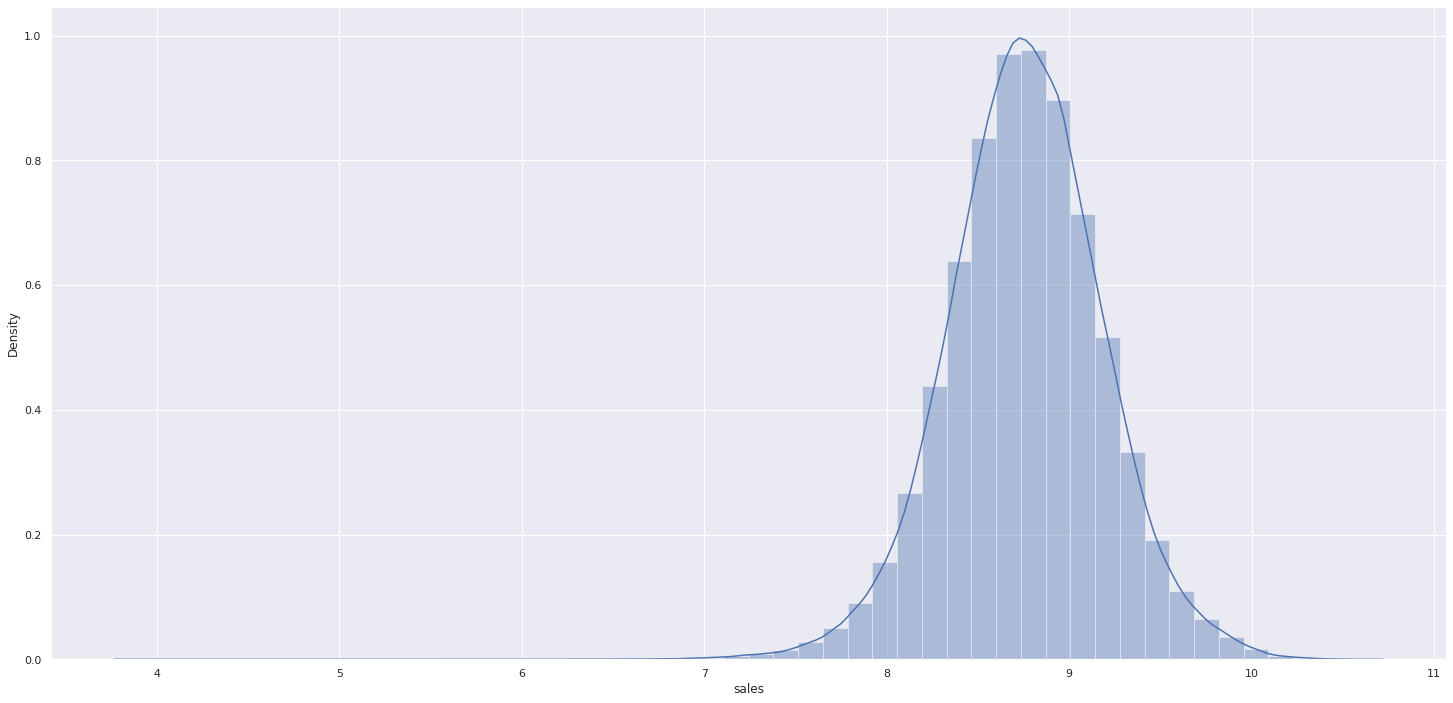

In [55]:
df5['sales']=np.log1p(df5['sales'])
sns.distplot(df5['sales'])

### 5.3.2. Nature transformation

In [56]:
#month
df5['month_sin']=df5['month'].apply(lambda x:np.sin(x*(2.*np.pi/12)))
df5['month_cos']=df5['month'].apply(lambda x:np.cos(x*(2.*np.pi/12)))

#day
df5['day_sin']=df5['day'].apply(lambda x:np.sin(x*(2.*np.pi/30)))
df5['day_cos']=df5['day'].apply(lambda x:np.cos(x*(2.*np.pi/30)))

#week of year
df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x:np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x:np.cos(x*(2.*np.pi/52)))

#day of week
df5['day_of_week_sin']=df5['week_of_year'].apply(lambda x:np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos']=df5['week_of_year'].apply(lambda x:np.cos(x*(2.*np.pi/7)))

# 6.0. FEATURE SELECTION

In [57]:
df6=df5.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_puplic_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,0.433884,-0.900969
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,0,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,0.433884,-0.900969
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,0,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,0.433884,-0.900969
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,0.433884,-0.900969
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,0.433884,-0.900969


## 6.1. Split dataframe into training and test dataset.

In [58]:
df6=df5.copy()

In [59]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [60]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as feature selector

In [61]:
'''#Training and test datset for Boruta
x_train_n=x_train.drop(['date','sales'],axis=1).values
y_train_n=y_train.values.ravel()

#Define RandomForestRegressor
rf=RandomForestRegressor(n_jobs=-1)

#Define Boruta
boruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)'''

"#Training and test datset for Boruta\nx_train_n=x_train.drop(['date','sales'],axis=1).values\ny_train_n=y_train.values.ravel()\n\n#Define RandomForestRegressor\nrf=RandomForestRegressor(n_jobs=-1)\n\n#Define Boruta\nboruta=BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)"

### 6.2.1. Best features from Boruta

In [62]:
'''cols_selected=boruta.support_.tolist()

#Best features from Boruta
x_train_fs=x_train.drop(['date','sales'],axis=1)
cols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()

#Not selected Boruta
cols_not_selected_boruta=np.setdiff1d(x_train_fs.columns,cols_selected_boruta)'''

"cols_selected=boruta.support_.tolist()\n\n#Best features from Boruta\nx_train_fs=x_train.drop(['date','sales'],axis=1)\ncols_selected_boruta=x_train_fs.iloc[:,cols_selected].columns.to_list()\n\n#Not selected Boruta\ncols_not_selected_boruta=np.setdiff1d(x_train_fs.columns,cols_selected_boruta)"

In [63]:
'''['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                      'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                      'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                      'week_of_year_cos']'''

"['store','promo','store_type','assortment','competition_distance','competition_open_since_month',\n                      'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',\n                      'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',\n                      'week_of_year_cos']"

## 6.3. Manual Feature selection

In [64]:
cols_selected_boruta=['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                      'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                      'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                      'week_of_year_cos']

#Columns to add
feat_to_add=['date','sales']
cols_selected_boruta_full=cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODELLING

In [65]:
df7=df6.copy()
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [66]:
aux1=x_test.copy()
aux1['sales']=y_test.copy()

#prediction
aux2=aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1=pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline=aux1['predictions']

#performance
baseline_results=ml_error('Averege Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_results

,Model Name,MAE,MAPE,RMSE
0,Averege Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [67]:
#model
lr=LinearRegression().fit(x_train,y_train)

#prediction
yhat_lr=lr.predict(x_test)

#performance
lr_results=ml_error('Linear Regressor',np.expm1(y_test),np.expm1(yhat_lr))
lr_results

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor,1892.994269,0.29581,2704.599069


### 7.2.1. Linear Regression Model- Cross Validation

In [68]:
lr_results_cv=cross_validation(x_training,5,'Linear Regression',lr,verbose=False)
lr_results_cv

          Model Name         MAE    MAPE         RMSE
0  Linear Regression  2678.09335  0.3158  3864.651202
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1934.933282  0.330855  2612.762554
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  1829.555903  0.307685  2551.746743
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  2087.465046  0.288563  3021.287367
          Model Name          MAE      MAPE         RMSE
0  Linear Regression  2000.365308  0.286234  2866.422745


,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2106.08 +/- 298.15,0.31 +/- 0.02,2983.37 +/- 472.32


## 7.3. Linear Regression Regularized Model-Lasso

In [69]:
#model
lrr=Lasso(alpha=0.01).fit(x_train,y_train)

#prediction
yhat_lrr=lrr.predict(x_test)

#performance
lrr_results=ml_error('Linear Regressor-Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
lrr_results

,Model Name,MAE,MAPE,RMSE
0,Linear Regressor-Lasso,1906.839269,0.29104,2763.909115


### 7.3.1. Linear Regression Regularized Model-Lasso-  Cross Validation

In [70]:
lrr_results_cv=cross_validation(x_training,5,'Lasso',lrr,verbose=False)
lrr_results_cv

  Model Name          MAE      MAPE        RMSE
0      Lasso  2768.483877  0.316684  3998.99456
  Model Name         MAE      MAPE         RMSE
0      Lasso  1862.95633  0.293219  2651.447103
  Model Name          MAE      MAPE         RMSE
0      Lasso  1819.274096  0.290315  2609.745043
  Model Name          MAE     MAPE         RMSE
0      Lasso  2172.743735  0.28614  3183.182033
  Model Name          MAE      MAPE         RMSE
0      Lasso  2026.137013  0.281923  2935.390668


,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2129.92 +/- 342.97,0.29 +/- 0.01,3075.75 +/- 506.13


## 7.4. Random Forest Regressor

In [71]:
#model
rf=RandomForestRegressor(n_estimators=10,n_jobs=-1,random_state=42).fit(x_train,y_train)

#prediction
yhat_rf=rf.predict(x_test)

#performance
rf_results=ml_error('Random Forest',np.expm1(y_test),np.expm1(yhat_rf))
rf_results

,Model Name,MAE,MAPE,RMSE
0,Random Forest,925.063142,0.144688,1294.485426


### 7.4.1. Random Forest Regressor-Cross validation

In [72]:
rf_results_cv=cross_validation(x_training,5,'Rendom Forest Regressor',rf,verbose=True)
rf_results_cv


KFold Number: 5
                Model Name          MAE      MAPE         RMSE
0  Rendom Forest Regressor  1396.980774  0.180719  1950.401439

KFold Number: 4
                Model Name          MAE      MAPE         RMSE
0  Rendom Forest Regressor  1268.710533  0.199634  1726.486898

KFold Number: 3
                Model Name         MAE      MAPE        RMSE
0  Rendom Forest Regressor  852.638521  0.139078  1207.93492

KFold Number: 2
                Model Name         MAE      MAPE         RMSE
0  Rendom Forest Regressor  1123.32081  0.152296  1598.105898

KFold Number: 1
                Model Name         MAE      MAPE         RMSE
0  Rendom Forest Regressor  999.490886  0.145077  1388.732314


,Model name,MAE CV,MAPE CV,RMSE CV
0,Rendom Forest Regressor,1128.23 +/- 192.1,0.16 +/- 0.02,1574.33 +/- 258.39


## 7.5. XGBoost Regressor

In [73]:
#model
model_xgb=xgb.XGBRegressor(objective='reg:squarederror',
                           eta=0.01,max_depth=10,
                           subsample=0.7,
                           colsample_bytree=0.9).fit(x_train,y_train)

#prediction
yhat_xgb=model_xgb.predict(x_test)

#performance
xgb_results=ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
xgb_results

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,973.755166,0.14954,1378.642172


### 7.5.1. XGBoost Regressor-Cross validation

In [74]:
xgb_results_cv=cross_validation(x_training,5,'XGBoost Regressor',model_xgb,verbose=True)
xgb_results_cv


KFold Number: 5
          Model Name          MAE     MAPE        RMSE
0  XGBoost Regressor  1321.737622  0.17569  1801.76181

KFold Number: 4
          Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1182.190261  0.183987  1590.829212

KFold Number: 3
          Model Name         MAE      MAPE         RMSE
0  XGBoost Regressor  946.851858  0.151917  1325.686943

KFold Number: 2
          Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1221.454845  0.166315  1739.250623

KFold Number: 1
          Model Name          MAE      MAPE         RMSE
0  XGBoost Regressor  1147.200745  0.164838  1592.791568


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1163.89 +/- 123.25,0.17 +/- 0.01,1610.06 +/- 164.3


## 7.6.ExtraTreesRegressor

In [75]:
#Model
etr=ExtraTreesRegressor(n_jobs=-1,random_state=42,n_estimators= 10)
etr_training=etr.fit(x_train,y_train)

#Predictions
yhat_etr=etr_training.predict(x_test)

#Performance
etr_results=ml_error('ExtraTreesRegressor',np.expm1(y_test),np.expm1(yhat_etr))
etr_results

,Model Name,MAE,MAPE,RMSE
0,ExtraTreesRegressor,967.537083,0.150838,1358.053711


###7.6.1. ExtraTreesRegressor-Cross validation

In [76]:
etr_results_cv=cross_validation(x_training,5,'ExtraTreesRegressor',etr,verbose=True)
etr_results_cv


KFold Number: 5
            Model Name          MAE      MAPE         RMSE
0  ExtraTreesRegressor  1265.010037  0.161884  1756.569135

KFold Number: 4
            Model Name         MAE      MAPE         RMSE
0  ExtraTreesRegressor  1315.86788  0.207648  1774.579444

KFold Number: 3
            Model Name         MAE      MAPE        RMSE
0  ExtraTreesRegressor  850.053331  0.138111  1210.17257

KFold Number: 2
            Model Name          MAE      MAPE        RMSE
0  ExtraTreesRegressor  1151.456467  0.159788  1613.47917

KFold Number: 1
            Model Name          MAE     MAPE         RMSE
0  ExtraTreesRegressor  1022.101431  0.15022  1410.786508


,Model name,MAE CV,MAPE CV,RMSE CV
0,ExtraTreesRegressor,1120.9 +/- 169.02,0.16 +/- 0.02,1553.12 +/- 215.38


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [77]:
modelling_results=pd.concat([baseline_results,lr_results,lrr_results,rf_results,xgb_results,etr_results])
modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest,925.063142,0.144688,1294.485426
0,ExtraTreesRegressor,967.537083,0.150838,1358.053711
0,XGBoost Regressor,973.755166,0.149540,1378.642172
0,Averege Model,1354.800353,0.455051,1835.135542
0,Linear Regressor,1892.994269,0.295810,2704.599069
0,Linear Regressor-Lasso,1906.839269,0.291040,2763.909115


### 7.6.1. Real Performance - Cross Validation

In [78]:
modelling_results_cv=pd.concat([lr_results_cv,lrr_results_cv,rf_results_cv,xgb_results_cv,etr_results_cv])
modelling_results_cv.sort_values('RMSE CV')

,Model name,MAE CV,MAPE CV,RMSE CV
0,ExtraTreesRegressor,1120.9 +/- 169.02,0.16 +/- 0.02,1553.12 +/- 215.38
0,Rendom Forest Regressor,1128.23 +/- 192.1,0.16 +/- 0.02,1574.33 +/- 258.39
0,XGBoost Regressor,1163.89 +/- 123.25,0.17 +/- 0.01,1610.06 +/- 164.3
0,Linear Regression,2106.08 +/- 298.15,0.31 +/- 0.02,2983.37 +/- 472.32
0,Lasso,2129.92 +/- 342.97,0.29 +/- 0.01,3075.75 +/- 506.13


# 8.0. PASSO 8 - HYPERPARAMETER FINE TUNING

In [79]:
df8=df7.copy()

## 8.1.Random Search

In [80]:
'''warnings.filterwarnings('ignore')

#params
params={   'n_estimators':      [1500,1700,2500,3000,3500],
           'eta':               [0.01,0.03],
           'max_depth':         [3,5,9],
           'subsample':         [0.1,0.5,0.7],
           'colsample_bytree':  [0.3,0.7,0.9],
           'min_child_weight':  [3,8,15]}

#model
model_xgb=xgb.XGBRegressor(    objective=          'reg:squarederror',
                               n_estimators=       params['n_estimators'],
                               eta=                params['eta'],
                               max_depth=          params['max_depth'],
                               subsample=          params['subsample'],
                               colsample_bytree=   params['colsample_bytree'],
                               min_child_weight=   params['min_child_weight'])
  
rscv = RandomizedSearchCV(model_xgb, params, random_state=0,cv=2,n_iter=5).fit(x_train, y_train)
rscv.best_params_'''

"warnings.filterwarnings('ignore')\n\n#params\nparams={   'n_estimators':      [1500,1700,2500,3000,3500],\n           'eta':               [0.01,0.03],\n           'max_depth':         [3,5,9],\n           'subsample':         [0.1,0.5,0.7],\n           'colsample_bytree':  [0.3,0.7,0.9],\n           'min_child_weight':  [3,8,15]}\n\n#model\nmodel_xgb=xgb.XGBRegressor(    objective=          'reg:squarederror',\n                               n_estimators=       params['n_estimators'],\n                               eta=                params['eta'],\n                               max_depth=          params['max_depth'],\n                               subsample=          params['subsample'],\n                               colsample_bytree=   params['colsample_bytree'],\n                               min_child_weight=   params['min_child_weight'])\n  \nrscv = RandomizedSearchCV(model_xgb, params, random_state=0,cv=2,n_iter=5).fit(x_train, y_train)\nrscv.best_params_"

## 8.2.Final Model

In [85]:
'''#params
params={   'colsample_bytree':  0.9,
           'eta':               0.01,
           'max_depth':         5,
           'min_child_weight':  15,
           'n_estimators':      3500,
           'subsample':         0.7}

#model
model_xgb=xgb.XGBRegressor(    objective=          'reg:squarederror',
                               n_estimators=       params['n_estimators'],
                               eta=                params['eta'],
                               max_depth=          params['max_depth'],
                               subsample=          params['subsample'],
                               colsample_bytree=   params['colsample_bytree'],
                               min_child_weight=   params['min_child_weight']).fit(x_train,y_train)

#Save trained model
pickle.dump(model_xgb,open('/content/model_xgb.pkl','wb'))'''

"#params\nparams={   'colsample_bytree':  0.9,\n           'eta':               0.01,\n           'max_depth':         5,\n           'min_child_weight':  15,\n           'n_estimators':      3500,\n           'subsample':         0.7}\n\n#model\nmodel_xgb=xgb.XGBRegressor(    objective=          'reg:squarederror',\n                               n_estimators=       params['n_estimators'],\n                               eta=                params['eta'],\n                               max_depth=          params['max_depth'],\n                               subsample=          params['subsample'],\n                               colsample_bytree=   params['colsample_bytree'],\n                               min_child_weight=   params['min_child_weight']).fit(x_train,y_train)\n\n#Save trained model\npickle.dump(model_xgb,open('/content/model_xgb.pkl','wb'))"

In [89]:
#prediction
model_xgb=pickle.load(open('/content/model_xgb.pkl','rb'))
yhat_xgb=model_xgb.predict(x_test) 

#performance
xgb_results=ml_error('XGBRegressor',np.expm1(y_test),np.expm1(yhat_xgb)) 
xgb_results

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,889.073067,0.132332,1263.100425


# 9.0. TRANSLATION AND INTERPRETATION OF THE ERROR

In [91]:
df9 = X_test[ cols_selected_boruta_full ]

#rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 9.1.Business Performance

In [92]:
#Sum of predictions
df91=df9[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1=df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2=df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#Merge
df9_aux3=pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92=pd.merge(df91,df9_aux3,how='inner',on='store')

#Scenários
df92['worst_scenario']=df92['predictions']-df92['MAE']
df92['best_scenario']=df92['predictions']+df92['MAE']

#order columns
df92=df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,157197.359375,156817.062804,157577.655946,380.296571,0.083632
1,2,168422.328125,167768.588320,169076.067930,653.739805,0.146804
2,3,258985.406250,258427.765473,259543.047027,557.640777,0.092393
3,4,329335.062500,328102.355812,330567.769188,1232.706688,0.117698
4,5,162826.375000,162213.924237,163438.825763,612.450763,0.170331


In [93]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,102861.187500,99423.525365,106298.849635,3437.662135,0.571554
908,909,240186.281250,232654.410560,247718.151940,7531.870690,0.511915
875,876,194385.375000,189729.349609,199041.400391,4656.025391,0.456197
432,433,203138.500000,201807.901759,204469.098241,1330.598241,0.321755
969,970,109731.898438,109088.078947,110375.717928,643.819491,0.314846


Text(0.5, 1.0, 'MAPE X Store')

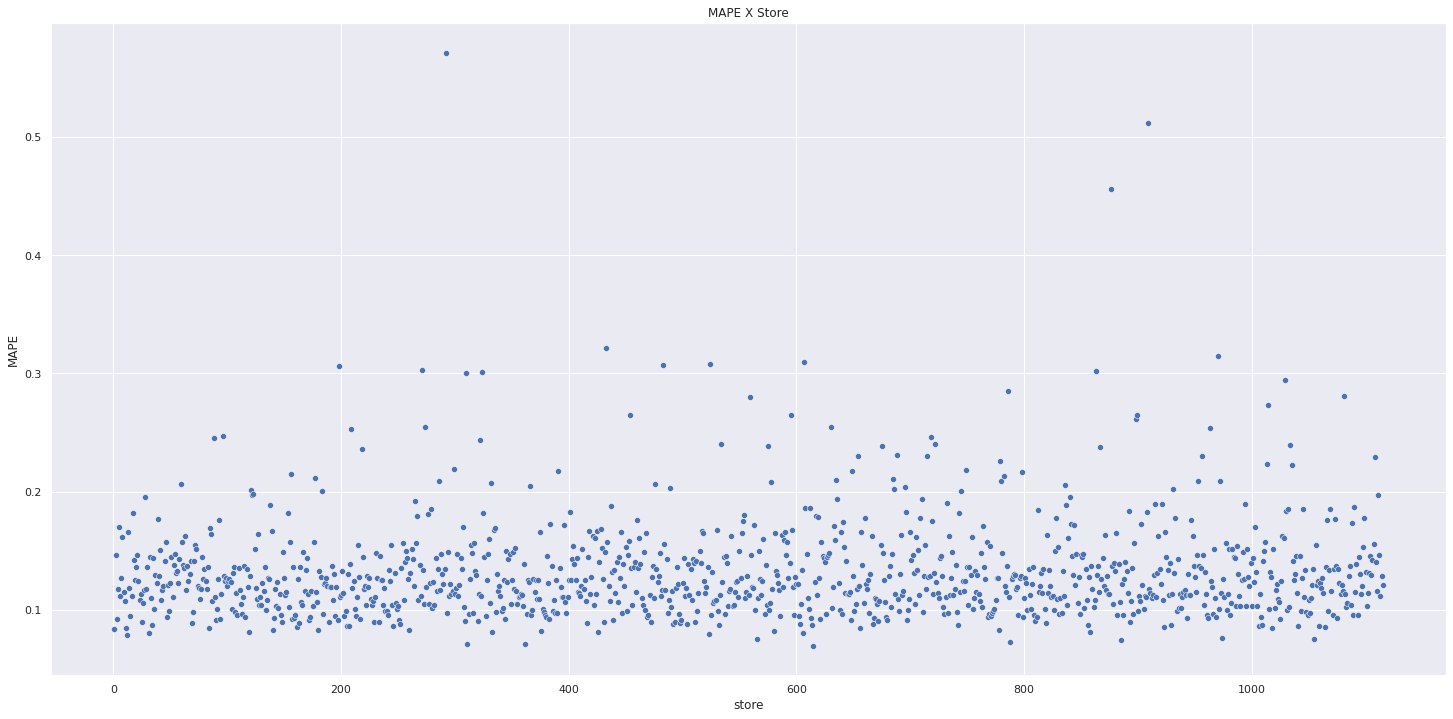

In [94]:
ax=sns.scatterplot(x='store',y='MAPE',data=df92)
ax.set_title('MAPE X Store')

## 9.2.Total Performance

In [95]:
df93=df92[['predictions','worst_scenario','best_scenario',]].apply(lambda x:np.sum(x),axis=0).reset_index().rename(columns={'index':'scenario',0:'values'})
df93['values']=df93['values'].map('R${:,.2f}'.format)
df93.head()

,scenario,values
0,predictions,"R$279,873,344.00"
1,worst_scenario,"R$278,880,218.57"
2,best_scenario,"R$280,866,433.90"


## 9.3.Machine Learning Performance

In [96]:
df9['error']=df9['sales']-df9['predictions']
df9['error_rate']=df9['predictions']/df9['sales']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


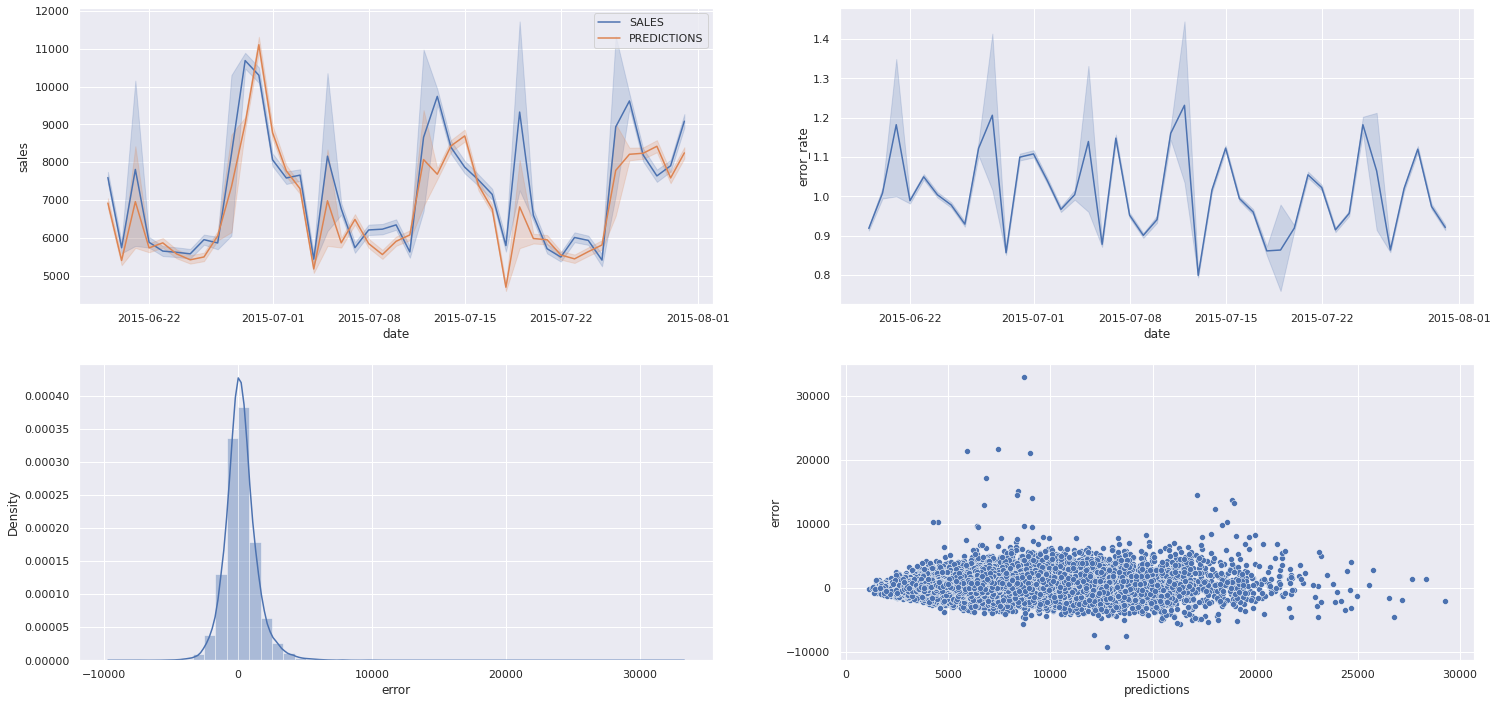

In [97]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])

# 10.0. DEPLOY MODEL TO PRODUCTION

##10.1.transformation class

In [98]:
'''import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class transformations(object): 
  def __init__(self):    
    self.competition_distance      =pickle.load(open('parameters/competition_distance_scaler.pkl','rb'))
    self.competition_time_month    =pickle.load(open('parameters/competition_time_month_scaler.pkl','rb'))
    self.promo_time_week           =pickle.load(open('parameters/promo_time_week_scaler.pkl','rb'))
    self.store_type                =pickle.load(open('parameters/store_type_scaler.pkl','rb'))
    self.year                      =pickle.load(open('parameters/year_scaler.pkl','rb'))
    self.df10                      =pd.read_csv('dataset_test/test.csv')
    self.df_store_raw              =pd.read_csv('dataset_test/store.csv',low_memory=False)


  def data_cleaning(self,df1):
    df1=df1.copy()    

    #rename
    columns={'Store':'store', 'DayOfWeek':'day_of_week', 'Date':'date',
         'Open':'open', 'Promo':'promo', 'StateHoliday':'state_holiday',                
         'SchoolHoliday':'school_holiday', 'StoreType':'store_type',
         'Assortment':'assortment', 'CompetitionDistance':'competition_distance',
         'CompetitionOpenSinceMonth':'competition_open_since_month',
         'CompetitionOpenSinceYear':'competition_open_since_year',
         'Promo2':'promo2','Promo2SinceWeek':'promo2_since_week',
         'Promo2SinceYear':'promo2_since_year', 'PromoInterval':'promo_interval'}

    df1=df1.rename(columns=columns)

    df1['date']=pd.to_datetime(df1['date'])

    #competition_distance
    df1['competition_distance'].max()
    max_value=200000
    df1['competition_distance']=df1['competition_distance'].apply(lambda x : max_value if math.isnan(x) else x)    

    #competition_open_since_month 
    df1['competition_open_since_month']=df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1) 

    #competition_open_since_year 
    df1['competition_open_since_year']=df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1) 
        
    #promo2
    #promo2_since_week
    df1['promo2_since_week']=df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)  

    #promo2_since_year  
    df1['promo2_since_year']=df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)  

    #promo_interval 
    month_map={1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dev'}   
    df1['promo_interval'].fillna(0,inplace=True) 
    df1['month_map']=df1['date'].dt.month.map(month_map)  
    df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval']==0 else 1 if x['month_map'] in x['promo_interval'].split(';') else 0,axis=1)

    #change types
    df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
    df1['competition_open_since_year']=  df1['competition_open_since_year'].astype(int)
    df1['promo2_since_week']=            df1['promo2_since_week'].astype(int)
    df1['promo2_since_year']=            df1['promo2_since_year'].astype(int)

    return df1


  def feature_engeneering(self,df2):
    df2=df2.copy()

    #year
    df2['year']=df2['date'].dt.year

    #month
    df2['month']=df2['date'].dt.month

    #day
    df2['day']=df2['date'].dt.day

    #week of year
    df2['week_of_year']=df2['date'].dt.weekofyear

    #year week
    df2['year_week']=df2['date'].dt.strftime('%Y-%W')

    #competition since
    df2['competition_since']=df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1),axis=1)
    df2['competition_time_month']=((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

    #promo since
    df2['promo_since']=df2['promo2_since_year'].astype(str)+'-'+df2['promo2_since_week'].astype(str)
    df2['promo_since']=df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x +'-1' ,'%Y-%W-%w')-datetime.timedelta(days=7))
    df2['promo_time_week']=((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

    #assortment
    df2['assortment']=df2['assortment'].apply(lambda x:'basic' if x=='a' else 'extra' if x=='b' else 'extended')
    #state holiday
    df2['state_holiday']=df2['state_holiday'].apply(lambda x:'puplic_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')
    return df2


  def data_preparation(self,df5):
    df5=df5.copy()
    #competition distance
    df5['competition_distance']=self.competition_distance.fit_transform(df5[['competition_distance']].values)    

    #competition time month
    df5['competition_time_month']=self.competition_time_month.fit_transform(df5[['competition_time_month']].values)
    
    #promo time week  
    df5['promo_time_week']=self.promo_time_week.fit_transform(df5[['promo_time_week']].values)
    
    #year
    df5['year']=self.year.fit_transform(df5[['year']].values)
    
    #state_holiday- One Hot Encoding
    df5=pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

    #store_type- Label Encoding    
    df5['store_type']=self.store_type.fit_transform(df5['store_type'])
    
    #assortment- Ordinal Encoding
    assortment_dict={'basic':1,'extra':2,'extended':3}
    df5['assortment']=df5['assortment'].map(assortment_dict)

    #month
    df5['month_sin']=df5['month'].apply(lambda x:np.sin(x*(2.*np.pi/12)))
    df5['month_cos']=df5['month'].apply(lambda x:np.cos(x*(2.*np.pi/12)))

    #day
    df5['day_sin']=df5['day'].apply(lambda x:np.sin(x*(2.*np.pi/30)))
    df5['day_cos']=df5['day'].apply(lambda x:np.cos(x*(2.*np.pi/30)))

    #week of year
    df5['week_of_year_sin']=df5['week_of_year'].apply(lambda x:np.sin(x*(2.*np.pi/52)))
    df5['week_of_year_cos']=df5['week_of_year'].apply(lambda x:np.cos(x*(2.*np.pi/52)))

    #day of week
    df5['day_of_week_sin']=df5['week_of_year'].apply(lambda x:np.sin(x*(2.*np.pi/7)))
    df5['day_of_week_cos']=df5['week_of_year'].apply(lambda x:np.cos(x*(2.*np.pi/7))) 

    cols_selected=['store','promo','store_type','assortment','competition_distance','competition_open_since_month',
                      'competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month',
                      'promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin',
                      'week_of_year_cos']

    return df5[cols_selected]


  def dataset (self,loja):

    # merge test dataset + store
    # loading test dataset    
    df10 = self.df10
    df_store_raw=self.df_store_raw        

    df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

    # choose store for prediction
    df_test = df_test[df_test['Store'].isin( [loja] )]

    # remove closed days
    df_test = df_test[df_test['Open'] != 0]
    df_test = df_test[~df_test['Open'].isnull()]
    df_test = df_test.drop( 'Id', axis=1 )

    return df_test

    
      

  def get_prediction(self,model,original_data,data_transform):

    #prediction
    pred=model.predict(data_transform)
    
    #join pred into the original data
    original_data['Predictions']=np.expm1(pred)

    return original_data   

  def prediction_calculator(self,df4):

    df4=df4.copy()    
    df4=df4[['Store','Predictions']].groupby('Store').sum().reset_index()    

    return df4.to_json(orient='records',date_format='iso') ''' 

"import pickle\nimport inflection\nimport pandas as pd\nimport numpy as np\nimport math\nimport datetime\n\n\nclass transformations(object): \n  def __init__(self):    \n    self.competition_distance      =pickle.load(open('parameters/competition_distance_scaler.pkl','rb'))\n    self.competition_time_month    =pickle.load(open('parameters/competition_time_month_scaler.pkl','rb'))\n    self.promo_time_week           =pickle.load(open('parameters/promo_time_week_scaler.pkl','rb'))\n    self.store_type                =pickle.load(open('parameters/store_type_scaler.pkl','rb'))\n    self.year                      =pickle.load(open('parameters/year_scaler.pkl','rb'))\n    self.df10                      =pd.read_csv('dataset_test/test.csv')\n    self.df_store_raw              =pd.read_csv('dataset_test/store.csv',low_memory=False)\n\n\n  def data_cleaning(self,df1):\n    df1=df1.copy()    \n\n    #rename\n    columns={'Store':'store', 'DayOfWeek':'day_of_week', 'Date':'date',\n         'Open'

## 10.2.API Handler

In [99]:
'''from flask                           import Flask,request,Response
from transformations.transformations import transformations
import os
import pickle
import pandas              as pd


#Loading model
model=pickle.load(open('model/model_xgb.pkl','rb'))

#Initialize API
app=Flask(__name__)

@app.route('/oi',methods=['POST'])
def diagnostico_predict():
  test_json=request.get_json()

  if test_json:
    if isinstance (test_json,dict):
      numero_da_loja=pd.DataFrame(test_json,index=[0])

    else:
      numero_da_loja=pd.DataFrame(test_json,columns=test_json[0].keys())

    #numero da loja
    loja=numero_da_loja['numero_da_loja'][0]
    
    #Isntantiate transformations
    pipeline=transformations() 

    #dataset test 
    test_raw=pipeline.dataset (loja) 
    if test_raw.shape[0] != 0:    

      #data cleaning
      df1=pipeline.data_cleaning(test_raw)  

      #feature engeneering
      df2=pipeline.feature_engeneering(df1)

      #data preparation
      df3=pipeline.data_preparation(df2)

      #predict
      df4=pipeline.get_prediction(model,test_raw,df3) 

      #prediction_calculator
      df5=pipeline.prediction_calculator(df4)   
        
      return df5

    else:
      df={'Predictions':['Nao existe essa loja !']}
      df=pd.DataFrame(data=df,columns=['Predictions'])
      
      return  df.to_json(orient='records',date_format='iso')    

  else:
    return Response('{}',status=200,mimetype='application/json')

if __name__ == "__main__":
    port = int(os.environ.get("PORT", 5000))
    app.run(host='0.0.0.0', port=port)'''

'from flask                           import Flask,request,Response\nfrom transformations.transformations import transformations\nimport os\nimport pickle\nimport pandas              as pd\n\n\n#Loading model\nmodel=pickle.load(open(\'model/model_xgb.pkl\',\'rb\'))\n\n#Initialize API\napp=Flask(__name__)\n\n@app.route(\'/oi\',methods=[\'POST\'])\ndef diagnostico_predict():\n  test_json=request.get_json()\n\n  if test_json:\n    if isinstance (test_json,dict):\n      numero_da_loja=pd.DataFrame(test_json,index=[0])\n\n    else:\n      numero_da_loja=pd.DataFrame(test_json,columns=test_json[0].keys())\n\n    #numero da loja\n    loja=numero_da_loja[\'numero_da_loja\'][0]\n    \n    #Isntantiate transformations\n    pipeline=transformations() \n\n    #dataset test \n    test_raw=pipeline.dataset (loja) \n    if test_raw.shape[0] != 0:    \n\n      #data cleaning\n      df1=pipeline.data_cleaning(test_raw)  \n\n      #feature engeneering\n      df2=pipeline.feature_engeneering(df1)\n\n    

## 10.3.API Tester

In [100]:
#Create dataset API
loja=20
df={'numero_da_loja':[loja]}
df=pd.DataFrame(data=df,columns=['numero_da_loja'])

#converter em json
df=json.dumps(df.to_dict(orient='records'))

#API call
path='https://sdjfnsdfbbbbb.herokuapp.com/'
url=path +'oi'
headers={'content-type':'application/json'}
data=df
r=requests.post(url,data=data,headers=headers)
print('Status code {}'.format(r.status_code))

Status code 200


In [101]:
#Predictions
df=pd.DataFrame(r.json(),columns=r.json()[0].keys())
df.head()

,Store,Predictions
0,20,272307.28125


##10.4. Streamlit app

In [102]:
'''import streamlit as st 
import json
import requests
import pandas as pd

@st.cache()
  
# function input
def prediction(loja):

  #Create dataframe
  df={'numero_da_loja':[loja]}
  df=pd.DataFrame(data=df,columns=['numero_da_loja'])
  
  #converter em json
  df1=json.dumps(df.to_dict(orient='records'))

  #API call
  path='https://sajhnfdcccccc.herokuapp.com/'
  url=path +'oi'
  headers={'content-type':'application/json'}  
  r=requests.post(url,data=df1,headers=headers)

  #Prediction
  df2=pd.DataFrame(r.json(),columns=r.json()[0].keys())
        
  return df2
      
  
# webapp  
def main():       
    # Config web
    html_temp = """ 
    <div style ="background-color:gray;padding:13px"> 
    <h1 style ="color:black;text-align:center;">Previsão de vendas</h1> 
    </div> 
    """
      
    # display 
    st.markdown(html_temp, unsafe_allow_html = True) 
      
    # Imput    
    loja =st.number_input('Número da loja')       
     
    result =""
      
    # Predict 
    if st.button("Predict"):        
        result = prediction(loja) 
        st.success('Previsão: {}'.format(result))
        
     
if __name__=='__main__': 
    main()'''

'import streamlit as st \nimport json\nimport requests\nimport pandas as pd\n\n@st.cache()\n  \n# function input\ndef prediction(loja):\n\n  #Create dataframe\n  df={\'numero_da_loja\':[loja]}\n  df=pd.DataFrame(data=df,columns=[\'numero_da_loja\'])\n  \n  #converter em json\n  df1=json.dumps(df.to_dict(orient=\'records\'))\n\n  #API call\n  path=\'https://sajhnfdcccccc.herokuapp.com/\'\n  url=path +\'oi\'\n  headers={\'content-type\':\'application/json\'}  \n  r=requests.post(url,data=df1,headers=headers)\n\n  #Prediction\n  df2=pd.DataFrame(r.json(),columns=r.json()[0].keys())\n        \n  return df2\n      \n  \n# webapp  \ndef main():       \n    # Config web\n    html_temp = """ \n    <div style ="background-color:gray;padding:13px"> \n    <h1 style ="color:black;text-align:center;">Previsão de vendas</h1> \n    </div> \n    """\n      \n    # display \n    st.markdown(html_temp, unsafe_allow_html = True) \n      \n    # Imput    \n    loja =st.number_input(\'Número da loja\')    